The quantities we need to compute:

* $P(x)$ - raw popularity of each song.  This should be estimated from a training set.

* $P(e ~|~ u)$ - probability of an edge given a user.  Each user has her own distribution over edges when constructing a transition, as estimated by the statistics of $x_s \odot x_t$ for each $(s, t)$ in the user's history.

* $P(x ~|~ e)$ - probability of a song given an edge.  Condition on membership in a particular edge.

  $$
    P(x ~|~ e) = \frac{P(x) \mathbb{1}[x \in e]}{\sum_{x' \in e} P(x')}
  $$
  
* $P(x ~|~ u, x_p)$ - probability of a song selection given the user and previous song $x_p$.  This can be decomposed in terms of the above as

$$
P(x ~|~ u, x_p) = \sum_e P(x, e ~|~ u, x_p) = \sum_{e} P(x ~|~ e, u) P(e ~|~ u, x_p) = \sum_e P(x ~|~ e) P(e ~|~ u, x_p)
$$

$$
P(e ~|~ u, x_p) = \frac{P(e ~|~ u) \mathbb{1}[x_p \in e]}{\sum_f P(f ~|~ u) \mathbb{1}[x_p \in f]}
$$

The questions we want to answer:

* Aesthetic diversity: for each user, what is $H(P(e~|~u, e \neq \text{uniform}))$?  
* Breadth vs depth: what is $H(P(e~|~u))$ vs $\mathbf{E}_{x\in u}[P(x~|~u)]$?

## Technicality details

The song $x$ is used to estimate $P(e|u)$, so we need to be careful about how we explain and interpret this quantity.  One way to think of it is: if we were to redraw a song $x$ given our crude knowledge about the user (edge affinity), how likely are we to get *this* song?  In other words, can a model of the user's general style (edges) and knowledge of the gross statistics of track selection (popularity) accurately inform the selection of the track?

  - If so, then the user is 'broad' in the sense that their preferences appear similar to the crowd
  - If not, then the user is 'deep', in that they're selecting unpopular tracks relative to others

## Should we be bayesian?

Probably we will need priors on the distributions $P(x)$ and $P(e | u)$.

* $P(x) \sim \textbf{Dirichlet}(\alpha_0)$  (assume the distribution over all songs is multinomial)
* $P(e ~|~ u) \sim \textbf{Dirichlet}(\alpha_1)$

To be fully bayesian, we should integrate out the posteriors in all relevant computations, rather than taking point estimates (modes).

In [1]:
import pandas as pd
import scipy
import numpy as np

import progressbar
import seaborn
import matplotlib.pyplot as plt
seaborn.set()
%matplotlib inline

In [2]:
def load_edges(*files, **kwargs):
    
    min_size = kwargs.get('min_size', 100)
    
    frames = [pd.read_pickle(_) for _ in files]
    frames = [frame.drop(frame.columns[frame.count() < min_size], axis=1).to_dense()
              for frame in frames]
    
    H = frames.pop(0)
    
    while len(frames):
        H = H.join(frames.pop(0), how='outer', sort=True)
    
    H.index.name = 'song_id'
    H = H.fillna(value=0.0)
    #H = H.to_sparse()
    return H

In [3]:
def p_edge_given_user(Ht, playlists, alpha=1.0, min_bigrams=5, max_users=None, count_unigrams=False):
    '''Estimate the edge distribution for each user.
    
    Parameters
    ----------
    Ht :  n_edges * n_songs dataframe
    
    playlists : hierarchical dataframe
    
    alpha : scalar or ndarray
        Vector of hyperparameters
        
    '''
    
    
    stats_frame = pd.DataFrame(columns=Ht.index, dtype='float32')
    
    if max_users is None:
        max_users = len(playlists.index.levels[0])
    
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=max_users).start()
    
    for user in playlists.index.levels[0]:
        
        if len(stats_frame) >= max_users:
            break
        
        u_stat = alpha
        n_bigrams = 0
        
        for (mix_id, segment_id), group in playlists.loc[user].groupby(level=[0,1]):
            if count_unigrams:
                u_stat = u_stat + Ht[group['song_id'][0]].to_dense()
                
            for s, t in zip(group['song_id'][:-1], group['song_id'][1:]):
                # Accumulate
                transition = Ht[s] * Ht[t]
                u_stat = u_stat + transition.to_dense()
                n_bigrams += 1
                          
        if n_bigrams < min_bigrams:
            continue
        
        model = scipy.stats.dirichlet(u_stat)
        stats_frame.loc[user] = model.mean()
        
        pbar.update(len(stats_frame.index))
    
    pbar.finish()
    
    return stats_frame

In [4]:
def song_given_edge(song_prob, H_T):
    
    mpe = H_T.dot(song_prob)
    
    return (H_T.divide(mpe['Probability'], axis='index') * song_prob['Probability'])    

In [5]:
def p_song_given_user(playlists, spe_t, edge_given_user, aggregate=scipy.stats.gmean):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['log probability'])
        
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        user_songs = playlists.loc[u]['song_id']
        u_vec = edge_given_user.loc[u]
        
        song_given_user = u_vec.dot(spe_t[user_songs]).to_frame()
        
        song_stats.loc[u] = song_given_user.apply(aggregate)[0]
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats.applymap(np.log)
        

In [6]:
def h_song_given_user(spe_t, edge_given_user):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['song entropy'])
        
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        u_vec = edge_given_user.loc[u]
        
        song_stats.loc[u] = scipy.stats.entropy(u_vec.dot(spe_t).values)
        
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats
        

In [7]:
def p_song_given_user_prev(playlists, spe_t, Ht, edge_given_user, aggregate=scipy.stats.gmean):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['log probability'])
    
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        user_songs = playlists.loc[u]['song_id']
        u_vec = edge_given_user.loc[u]
        
        song_given_user = []
        
        for (mix_id, segment_id), group in playlists.loc[u].groupby(level=[0,1]):
            for s, t in zip(group['song_id'][:-1], group['song_id'][1:]):
                # Accumulate
                u_vec = (Ht[s] * edge_given_user.loc[u]).to_dense()
                song_given_user.append(u_vec.T.dot(spe_t[t].to_dense()) / u_vec.sum())
                #song_given_user.append(u_vec.T.dot(spe_t[t]) / u_vec.sum())
        
        song_stats.loc[u] = pd.DataFrame(song_given_user).apply(aggregate)[0]
        
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats.applymap(np.log)
        

In [8]:
def song_counts(playlists, songs):
    raw_counts = pd.Series(data=0.0, index=songs) + playlists.groupby('song_id')['timestamp'].aggregate('count')
    raw_counts = raw_counts.fillna(0).to_frame(name='Counts')
    raw_counts.index.name = 'song_id'
    
    return raw_counts

In [9]:
def p_song(playlists, songs, alpha=1.0):
    
    K = len(songs)
    
    raw_counts = song_counts(playlists, songs)
    
    model = scipy.stats.dirichlet(alpha=raw_counts['Counts'] + alpha)
    
    probs = pd.DataFrame(index=raw_counts.index,
                         columns=['Probability'],
                         data=model.mean())
    
    return probs

In [10]:
def get_song_names():
    
    song_names = pd.read_json('/home/bmcfee/git/playlist_recommender/data/valid_songs.json', orient='index')
    song_names.index.name = 'song_id'
    return song_names

In [11]:
def get_user(playlists, user):
    
    return playlists.loc[[user]].join(song_names, on='song_id')

In [12]:
song_names = get_song_names()

In [13]:
fold = 0

In [109]:
playlists_train = pd.read_pickle('/home/bmcfee/git/playlist_recommender/data/folds/{:d}_train.pickle'.format(fold))
playlists_test = pd.read_pickle('/home/bmcfee/git/playlist_recommender/data/folds/{:d}_test.pickle'.format(fold))

In [110]:
playlists_train = playlists_train[playlists_train['category'] != 'Single Artist']
playlists_test = playlists_test[playlists_test['category'] != 'Single Artist']

In [111]:
H_frame = load_edges('/home/bmcfee/git/playlist_recommender/data/edges/uniform.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/tags.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/era_decade.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/era_year.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/audio.pickle',
                     min_size=200)

In [112]:
H_frame_T = pd.DataFrame(index=H_frame.columns,
                         columns=H_frame.index,
                         data=H_frame.values.T)

In [113]:
song_prob = p_song(playlists_train, H_frame.index)

In [114]:
spe_t = song_given_edge(song_prob, H_frame_T)

In [115]:
scipy.stats.entropy(song_prob)

array([ 10.73572535])

In [116]:
song_prob.describe()

,Probability
count,114464.000000
mean,0.000009
std,0.000022
min,0.000002
25%,0.000003
50%,0.000003
75%,0.000006
max,0.000942


In [117]:
song_names.loc[song_prob['Probability'].argmax()]

artist                  Pixies
title        Where Is My Mind?
track_id    TRNNGMK128F423F034
Name: SOBBKGF12A8C1311EE, dtype: object

In [118]:
p_egu = p_edge_given_user(H_frame_T, playlists_test, count_unigrams=True, min_bigrams=10, alpha=0.5)

In [119]:
edge_diversity = p_egu.drop('[UNIFORM]', axis=1).apply(scipy.stats.entropy, axis=1).to_frame(name='Entropy')

In [120]:
track_diversity = h_song_given_user(spe_t, p_egu)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:02:54


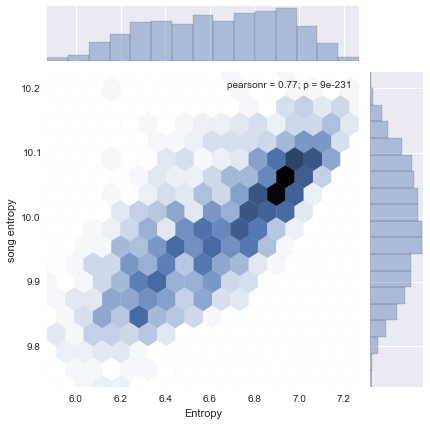

In [121]:
seaborn.jointplot(edge_diversity['Entropy'],
                  track_diversity['song entropy'],
                  kind='hex')

In [122]:
P = p_song_given_user(playlists_test, spe_t, p_egu)

In [123]:
P2 = p_song_given_user_prev(playlists_test, spe_t, H_frame_T, p_egu)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:01:53


Using localized song selection probability


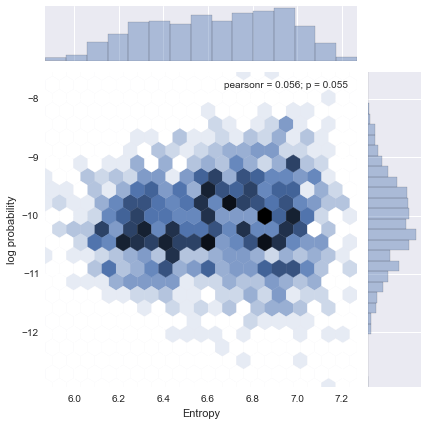

In [124]:
print 'Using localized song selection probability'
seaborn.jointplot(edge_diversity['Entropy'],
                  P2.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

H(Song | user) vs log P(Song = x_t | user, prev)


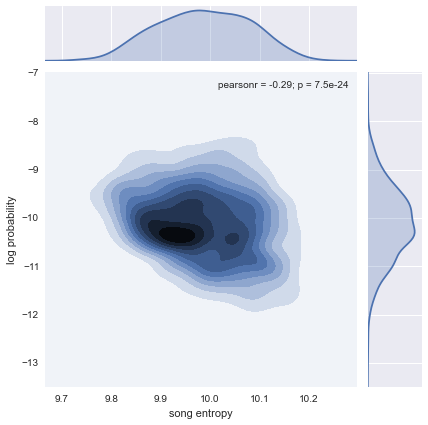

In [125]:
print 'H(Song | user) vs log P(Song = x_t | user, prev)'
seaborn.jointplot(track_diversity['song entropy'], 
                  P2.loc[p_egu.index]['log probability'],
                  kind='kde')
pass

H(Song | user) vs log P(Song = x_t | user)


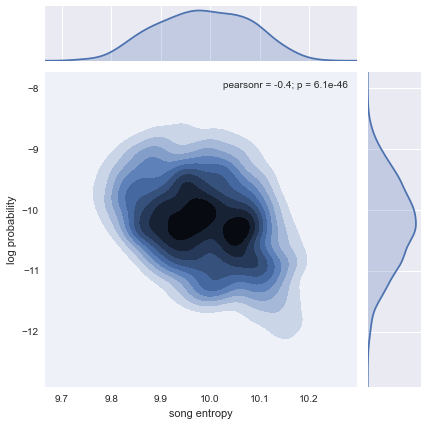

In [126]:
print 'H(Song | user) vs log P(Song = x_t | user)'
seaborn.jointplot(track_diversity['song entropy'], 
                  P.loc[p_egu.index]['log probability'],
                  kind='kde')
pass

Using global song selection probability


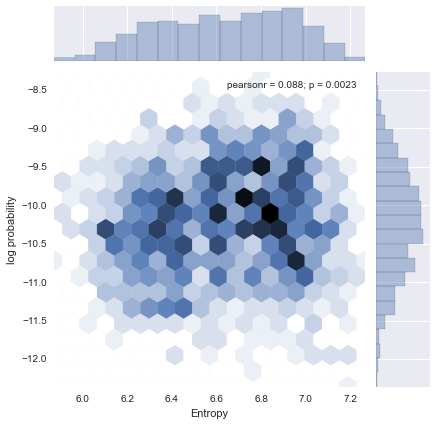

In [127]:
print 'Using global song selection probability'
seaborn.jointplot(edge_diversity['Entropy'],
                  P.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

---
## User investigation

In [128]:
num_songs = playlists_test.groupby(level=[0,1,2])[['song_id']].count()

In [129]:
num_segments = num_songs.groupby(level=[0,1]).count()

In [130]:
user_bigram_count = (num_songs.groupby(level=[0,1]).sum() - num_segments).groupby(level=0).sum()
user_bigram_count.columns = ['bigrams']

In [131]:
#ent_vs_big = edge_diversity.join(user_bigram_count).dropna()
ent_vs_big = track_diversity.join(user_bigram_count).dropna()

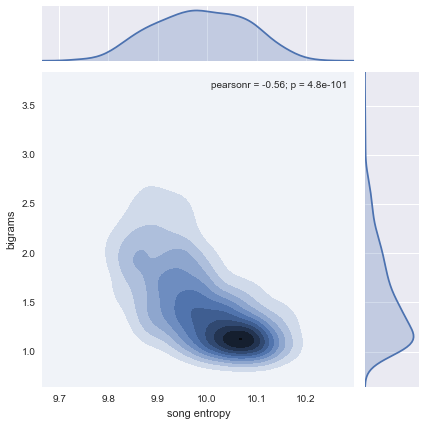

In [132]:
seaborn.jointplot(ent_vs_big['song entropy'],
                  np.log10(ent_vs_big['bigrams']),
                  kind='kde')

In [133]:
track_diversity.join(P2)

,song entropy,log probability
'drew,10.07364,-11.888170
*Meredith*,9.950924,-9.792944
*joshua*,10.07859,-9.802431
-M-D-J-,9.968495,-9.737036
.discourageo,10.08815,-10.768408
.e,9.967314,-10.544891
12345678910,10.03249,-10.949827
2bc,9.970585,-10.495517
=w=Jess=w=,9.88562,-9.789703
ANDREW12,9.981122,-9.421583


In [134]:
user_descriptions = track_diversity.join(P2)
user_descriptions.describe()

,log probability
count,1187.000000
mean,-10.118139
std,0.747823
min,-12.930588
25%,-10.591781
50%,-10.138864
75%,-9.616565
max,-7.532322


In [135]:
user_descriptions['song entropy']

'drew                   10.07364
*Meredith*              9.950924
*joshua*                10.07859
-M-D-J-                 9.968495
.discourageo            10.08815
.e                      9.967314
12345678910             10.03249
2bc                     9.970585
=w=Jess=w=               9.88562
ANDREW12                9.981122
ATF_206                 10.02957
Abe12                   9.863453
Adam Gimbel             10.00446
Adam123456              10.08512
AdamC                   9.876799
Adobe Sound Lab         10.00272
Adrian1                 9.987766
Aeichele                9.887442
Aguilar                 9.810758
Aguilar1                10.08485
Airria                  9.886931
Alan Barr               10.06466
Alan123                 9.984052
Alex Autumn             10.10773
Alex1234567890          9.925996
Alison123456            9.837889
Alius                    10.1338
Allen D                 9.962354
Amanda12345678906667    9.958904
Amy1234567890666        9.985261
          

In [136]:
import cPickle as pickle

In [137]:
with open('../../data/playlist_analysis_data_alpha0.5_2.pickle', mode='w') as fdesc:
    pickle.dump(dict(p_egu=p_egu,
                     user_descriptions=user_descriptions,
                     playlists_test=playlists_test),
                fdesc, protocol=-1)

In [138]:
import IPython.display

In [139]:
ux = user_descriptions['song entropy'].copy()
ux.sort()

In [140]:
lowest_entropy_users = ux.head(10)
highest_entropy_users = ux.tail(10)[::-1]
median_entropy_users = ux._iloc[len(ux)//2 - 5 : len(ux)//2 + 5]

In [141]:
print 'Broadest users'
for user in highest_entropy_users.index:
    print highest_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Broadest users
hopey    10.22599
Name: song entropy, dtype: object


category             song_id  \
user  mix_id segment_id segment_position                                    
hopey 3531   0          0                       Theme  SOVEIHU12A8AE45838   
                        1                       Theme  SOJAFDA12AF729A92C   
             1          0                       Theme  SOMNFRM12AB0183570   
                        1                       Theme  SOAJXPO12AB018C77E   
             2          0                       Theme  SOPMLHM12A8C13F558   
      3532   0          0                       Theme  SOVEIHU12A8AE45838   
                        1                       Theme  SOJAFDA12AF729A92C   
             1          0                       Theme  SOMNFRM12AB0183570   
                        1                       Theme  SOAJXPO12AB018C77E   
             2          0                       Theme  SOPMLHM12A8C13F558   
      3533   0          0                       Theme  SOVEIHU12A8AE45838   
                        1                       Theme  SOJAFDA12AF729A92C   
             1          0                       Theme  SOMNFRM12AB0183570   
                        1                       Theme  SOAJXPO12AB018C77E   
             2          0                       Theme  SOPMLHM12A8C13F558   
      3534   0          0                       Theme  SOVEIHU12A8AE45838   
                        1                       Theme  SOJAFDA12AF729A92C   
             1          0                       Theme  SOMNFRM12AB0183570   
                        1                       Theme  SOAJXPO12AB018C77E   
             2          0                       Theme  SOPMLHM12A8C13F558   
      3535   0          0                       Theme  SOVEIHU12A8AE45838   
                        1                       Theme  SOJAFDA12AF729A92C   
             1          0                       Theme  SOMNFRM12AB0183570   
                        1                       Theme  SOAJXPO12AB018C77E   
             2          0                       Theme  SOPMLHM12A8C13F558   
      3536   0          0                       Theme  SOVEIHU12A8AE45838   
                        1                       Theme  SOJAFDA12AF729A92C   
             1          0                       Theme  SOMNFRM12AB0183570   
                        1                       Theme  SOAJXPO12AB018C77E   
             2          0                       Theme  SOPMLHM12A8C13F558   
      3540   0          0                 Mixed Genre  SOFLBJC12A58A81771   
                        1                 Mixed Genre  SOAUKIS12A58A7F424   
             1          0                 Mixed Genre  SOQKGQJ12A8C136E68   
                        1                 Mixed Genre  SOMEHQV12A6D4FADF2   
             2          0                 Mixed Genre  SOESFKC12A6D4F8F4B   
             4          0                 Mixed Genre  SOMQXGF12A6D4FADF5   
             5          0                 Mixed Genre  SOXMFSC12A8C134B49   
             6          0                 Mixed Genre  SOWXXEN12A58A7D94D   

                                             timestamp        artist  \
user  mix_id segment_id segment_position                               
hopey 3531   0          0                 949429380000        Jawbox   
                        1                 949429380000      The Gits   
             1          0                 949429380000  Naked Raygun   
                        1                 949429380000    Jawbreaker   
             2          0                 949429380000        Jawbox   
      3532   0          0                 949429380000        Jawbox   
                        1                 949429380000      The Gits   
             1          0                 949429380000  Naked Raygun   
                        1                 949429380000    Jawbreaker   
             2          0                 949429380000        Jawbox   
      3533   0          0                 949429440000        Jawbox   
                        1   


mindy    10.21472
Name: song entropy, dtype: object


category             song_id  \
user  mix_id segment_id segment_position                                    
mindy 13514  0          0                 Mixed Genre  SOUCDDI12A8C13BBA6   
             1          0                 Mixed Genre  SODASVO12A8C139E3A   
                        1                 Mixed Genre  SOKKUEJ12AB01884B5   
             3          0                 Mixed Genre  SOACKNX12A6D4F7E6F   
             4          0                 Mixed Genre  SOIGMDZ12AB0181B2D   
             5          0                 Mixed Genre  SOJHFBV12A8C13BBDC   
             6          0                 Mixed Genre  SOVCBSZ12A8C13B76F   
                        1                 Mixed Genre  SOSAWRN12A8C13C691   
             7          0                 Mixed Genre  SOASYIU12A8C139E71   
      13515  0          0                 Mixed Genre  SOVRVAB12A8C13B67D   
                        1                 Mixed Genre  SONCVSQ12A8C13C6CA   
             1          0                 Mixed Genre  SOLSEVN12A6D4F6127   
             2          0                 Mixed Genre  SOYHJOV12A8C1367E9   
             3          0                 Mixed Genre  SOAZPHX12A8AE46961   
                        1                 Mixed Genre  SOMMFRP12AB01849A2   
             4          0                 Mixed Genre  SODKHER12AB0186FD8   
             5          0                 Mixed Genre  SONWLLL12A6310D7F9   
             6          0                 Mixed Genre  SOLNYUR12A6310D7F7   
      14766  0          0                 Mixed Genre  SOYGWDD12A8AE47F23   
             1          0                 Mixed Genre  SOTYERQ12A8C139E50   
             2          0                 Mixed Genre  SOSYPTQ12A8AE469A9   
             3          0                 Mixed Genre  SOLJRJX12AB01849BA   
             4          0                 Mixed Genre  SOLRYVH12AB0188061   
      15291  0          0                 Mixed Genre  SOQKWRJ12A8C13D0C8   
             1          0                 Mixed Genre  SOHGYNZ12A8C13E052   
      15393  0          0                 Mixed Genre  SOBNWZP12AAA8C875C   
                        1                 Mixed Genre  SOGLWVQ12AF72A671A   
                        2                 Mixed Genre  SOEHTDI12A58A7BD81   
             1          0                 Mixed Genre  SOJMONY12A8C13BBC8   
             2          0                 Mixed Genre  SOKKUEJ12AB01884B5   
...                                               ...                 ...   
      17015  4          0                 Mixed Genre  SOBFHII12A67ADE2D2   
      17815  0          0                 Mixed Genre  SOWYUZG12AB0180317   
                        1                 Mixed Genre  SOEATAL12A6D4FC133   
             1          0                 Mixed Genre  SOIHZGS12AB017DC06   
             2          0                 Mixed Genre  SOOJBOO12AB0187196   
             3          0                 Mixed Genre  SOQOQVJ12AB0181C62   
      20561  0          0                 Mixed Genre  SOAXTUL12A8AE47385   
             1          0                 Mixed Genre  SOYXEVN12A8C139E4E   
             2          0                 Mixed Genre  SOJHFBV12A8C13BBDC   
             4          0                 Mixed Genre  SOUNALP12A8C134EEC   
             5          0                 Mixed Genre  SOOECUI12A8C13AB67   
      20591  0          0                        Punk  SOPCOVY12AB0183042   
                        1                        Punk  SOAPPHZ12A8C13BBC5   
             1          0                        Punk  SOKVCPZ12AAA8C66FE   
             3          0                        Punk  SOWAAJI12A8AE46662   
             4          0                        Punk  SOXKYRJ12AF72A2D85   
      21071  0          0                   Road Trip  SOLJRJX12AB01849BA   
             1          0                   Road Trip  SOLRYVH12AB0188061   
                        1                   Road Trip  SOWAAJI12A8AE46662   
             2          0                


Dex    10.20614
Name: song entropy, dtype: object


category             song_id  \
user mix_id segment_id segment_position                                    
Dex  2722   1          0                 Mixed Genre  SONXDQB12A8C135E21   
            2          0                 Mixed Genre  SOBFMTW12A8C135360   
            3          0                 Mixed Genre  SOUZKYQ12A6D4F9BA2   
            4          0                 Mixed Genre  SOEALEY12A8C1379A5   
     4443   0          0                 Mixed Genre  SOSLUKB12A6D4F9B9C   
                       1                 Mixed Genre  SOZDDKY12A8C13B81B   
            1          0                 Mixed Genre  SOUPLZE12AAF3B29FD   
            2          0                 Mixed Genre  SOSZLXT12AB0187BFF   
                       1                 Mixed Genre  SOEEFJN12A6D4FA604   
                       2                 Mixed Genre  SOMWWTX12A6701C969   
            3          0                 Mixed Genre  SOPRXPJ12A8C1354B5   
            4          0                 Mixed Genre  SOHIPUV12A8C133818   
                       1                 Mixed Genre  SOINQNL12A8C13ADD1   
     6494   0          0                 Mixed Genre  SOMGKDF12AB0182875   
            1          0                 Mixed Genre  SOEEZZE12AB0189612   
            2          0                 Mixed Genre  SOPGGFB12A8C13E9D6   
            3          0                 Mixed Genre  SOMZVXI12A6D4FCC5B   
                       1                 Mixed Genre  SOTVYIW12A8C13107E   
                       2                 Mixed Genre  SOUPGPV12A58A7698C   
            4          0                 Mixed Genre  SOQVAJN12A8C134C01   
                       1                 Mixed Genre  SOJZLBO12AB0184635   
                       2                 Mixed Genre  SOKXQFS12A8C1427AF   
                       3                 Mixed Genre  SOAFIFR12A58A7BABC   
                       4                 Mixed Genre  SOHMLAZ12A8C143145   
                       5                 Mixed Genre  SONEKLN12AB0186891   

                                            timestamp  \
user mix_id segment_id segment_position                 
Dex  2722   1          0                 941246580000   
            2          0                 941246580000   
            3          0                 941246580000   
            4          0                 941246580000   
     4443   0          0                 956977020000   
                       1                 956977020000   
            1          0                 956977020000   
            2          0                 956977020000   
                       1                 956977020000   
                       2                 956977020000   
            3          0                 956977020000   
            4          0                 956977020000   
                       1                 956977020000   
     6494   0          0                 967862280000   
            1          0                 967862280000   
            2          0                 967862280000   
            3          0                 967862280000   
                       1                 967862280000   
                       2                 967862280000   
            4          0                 967862280000   
                       1                 967862280000   
                       2                 967862280000   
                       3                 967862280000   
                       4                 967862280000   
                       5                 967862280000   

                                                                             artist  \
user mix_id segment_id segment_position                                               
Dex  2722   1          0                                                   Sylk 130   
            2          0                       Patsy Montana & The Prairie Ramblers   
            3          0                                 United Future Organization   
            4   


Andruce    10.19659
Name: song entropy, dtype: object


category             song_id  \
user    mix_id segment_id segment_position                                    
Andruce 6920   0          0                 Mixed Genre  SODMAYX12A6D4F7AC4   
               1          0                 Mixed Genre  SOSJVCO12A8C136E93   
                          1                 Mixed Genre  SOERSBA12A6D4F9823   
               2          0                 Mixed Genre  SOQWSCJ12A8AE46F1C   
                          1                 Mixed Genre  SOANAXD12A8C131EE5   
                          2                 Mixed Genre  SOWTICW12A6D4FB01C   
                          3                 Mixed Genre  SORKLFE12A8C13714A   
               3          0                 Mixed Genre  SOGWZLB12AB017D019   
                          1                 Mixed Genre  SOIJNRR12A8C1398DA   
               4          0                 Mixed Genre  SOIIJMZ12AB018D1C2   
                          1                 Mixed Genre  SOPARAM12A6D4F80AD   
                          2                 Mixed Genre  SOBBSGU12A6D4FB8E0   
                          3                 Mixed Genre  SOFLPNB12A6701CFAE   
                          4                 Mixed Genre  SOLHPPH12A8C135426   
               5          0                 Mixed Genre  SOORSAZ12A8C13F5C5   
                          1                 Mixed Genre  SOXVSTE12AB017C6A8   
                          2                 Mixed Genre  SOXLBRB12AF729DD4F   
               6          0                 Mixed Genre  SOYQGNF12A6310D857   

                                               timestamp  \
user    mix_id segment_id segment_position                 
Andruce 6920   0          0                 970355640000   
               1          0                 970355640000   
                          1                 970355640000   
               2          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
                          3                 970355640000   
               3          0                 970355640000   
                          1                 970355640000   
               4          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
                          3                 970355640000   
                          4                 970355640000   
               5          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
               6          0                 970355640000   

                                                                       artist  \
user    mix_id segment_id segment_position                                      
Andruce 6920   0          0                                      Beastie Boys   
               1          0                                       Nerf Herder   
                          1                                     The Wannadies   
               2          0                                       The Prodigy   
                          1                 Sly & The Family Stone;Devin Lima   
                          2                                            Weezer   
                          3                                   Third Eye Blind   
               3          0                                   Jungle Brothers   
                          1                                       Get Up Kids   
               4          0                                  The Promise Ring   
                          1                                 Edison Lighthouse   
                          2                                        The Queers   
                          3                                         The Roots   
                          4                       


jima    10.19119
Name: song entropy, dtype: object


category             song_id  \
user mix_id segment_id segment_position                                    
jima 2690   0          0                 Mixed Genre  SONTVVW12A8C13094F   
                       1                 Mixed Genre  SOBSQYL12AB0188191   
            1          0                 Mixed Genre  SOFWTEN12A6D4F86B7   
            2          0                 Mixed Genre  SOTOOFM12A8C144EA6   
            3          0                 Mixed Genre  SOCPDYE12AB0183875   
     3547   0          0                 Mixed Genre  SOZDACW12AB01835E9   
            1          0                 Mixed Genre  SOELDFH12A6D4FB308   
            2          0                 Mixed Genre  SOYJMVI12AB018C0FF   
            3          0                 Mixed Genre  SODAPXL12A58A7B598   
                       1                 Mixed Genre  SOXTUTI12A8C1315B6   
            4          0                 Mixed Genre  SOCQAOI12A8C136EE1   
                       1                 Mixed Genre  SOQTITX12AB018C103   
            5          0                 Mixed Genre  SOKDRQU12A8C13C044   
     5042   0          0                 Mixed Genre  SORNYXF12A8C134AE0   
            1          0                 Mixed Genre  SOGSDGY12AB0183C8F   
            2          0                 Mixed Genre  SOXJINW12A6BD5578C   
                       1                 Mixed Genre  SOKQJZN12AB0183CA5   
            3          0                 Mixed Genre  SOVPDJM12A58A7D23C   
            4          0                 Mixed Genre  SOPWNLV12A8C134B18   
     5043   0          0                       Theme  SONKMKO12A8C146D14   
            1          0                       Theme  SOZYITX12AF72A0F1E   
            2          0                       Theme  SONVIUN12A8C1443C8   
            3          0                       Theme  SOKTTPK12A679D8AFD   
     7478   0          0                       Theme  SOAAFJC12A6D4F815F   
            1          0                       Theme  SOUEUMQ12AB0185C0B   
            2          0                       Theme  SOCYTME12A8C139462   
     9264   0          0                 Mixed Genre  SODVALH12AB0185936   
            1          0                 Mixed Genre  SOOFJAI12A6D4F6F24   
            2          0                 Mixed Genre  SOJNZJR12A6D4FB323   
            3          0                 Mixed Genre  SOCHYDG12AC3DF686E   
...                                              ...                 ...   
     12440  4          0                 Mixed Genre  SOGRZGP12A8C13D750   
                       1                 Mixed Genre  SOZCPDL12AB0183C9C   
                       2                 Mixed Genre  SOJZNML12AB01853B7   
     17766  0          0                 Mixed Genre  SOETYPJ12A8C1365EE   
            1          0                 Mixed Genre  SONWKVK12A8C140B9F   
            2          0                 Mixed Genre  SOKFGCJ12A6D4FCA12   
            3          0                 Mixed Genre  SOHYQKU12A8C140A43   
            4          0                 Mixed Genre  SOKNHMS12AB0181393   
                       1                 Mixed Genre  SOTBTDM12A58A7F11A   
            5          0                 Mixed Genre  SOJJOAX12A8C140BB5   
            6          0                 Mixed Genre  SOIOHQA12AB017AAEC   
                       1                 Mixed Genre  SOPBDPO12AC4689C02   
     19245  0          0                       Theme  SOHUKXS12A6D4FC374   
     32363  0          0                 Mixed Genre  SOSTEWE12A6D4F9B63   
            1          0                 Mixed Genre  SOPEVWM12AB018C144   
                       1                 Mixed Genre  SOSWKUM12A6D4F9FB1   
            2          0                 Mixed Genre  SOTIRPV12A8C13A96A   
            3          0                 Mixed Genre  SOJAWEF12A8C13C273   
     58785  0          0                 Mixed Genre  SODVALH12AB0185936   
            1          0                 Mixed Genre  SOXZQXD12AF72AA551   
            2   


joey de vivre    10.18839
Name: song entropy, dtype: object


category             song_id  \
user          mix_id segment_id segment_position                                
joey de vivre 8070   0          0                   Theme  SOTEJIP12A58A7DD6F   
                     1          0                   Theme  SOSGQNO12A8C13DF4F   
                     2          0                   Theme  SOVOXMY12AB017F88B   
                     3          0                   Theme  SONGRYV12A8C133BE1   
              8073   0          0                   Theme  SOHIHFC12AB018B621   
                     1          0                   Theme  SOGIGEN12A58A7B9A2   
                     2          0                   Theme  SODJMFT12AB018D2E8   
                     3          0                   Theme  SOXHVVU12A8C143D21   
                                1                   Theme  SOYTKLF12AB0186AED   
              8074   0          0                   Theme  SOEEXED12A8C13DBF1   
                                1                   Theme  SOFIWXE12A8C13F200   
                     1          0                   Theme  SOJCNDC12AC468708D   
                     3          0                   Theme  SOFGVDE12AB018A5FC   
                     4          0                   Theme  SOMWYCK12A8C13239C   
                     6          0                   Theme  SOBKLHH12AB017FF7D   
                                1                   Theme  SORGEZM12A8C13DC1E   
              8167   0          0                   Theme  SOGIAQB12A8C13B228   
                     1          0                   Theme  SOUXROM12AB018E959   
                     2          0                   Theme  SOJWLKW12A8C143E7B   
                     3          0                   Theme  SOKITRY12AB018B5AE   
              8188   0          0                   Theme  SORNWTY12AB0182C29   
                     1          0                   Theme  SODAGMY12AB0180550   
                                1                   Theme  SOHOXZW12AB01835A2   
                     2          0                   Theme  SOMGLSU12AAF3B30C6   
                     3          0                   Theme  SOHFWCT12AB0185BA6   
                     4          0                   Theme  SORWSJX12AB0185B23   
                                1                   Theme  SOGXVOA12AB017D688   
                     5          0                   Theme  SOWXEVE12A58A7F24E   
              8211   0          0                   Theme  SOFHMRG12A8C14554A   
                                1                   Theme  SOXHEEB12AB018CDA2   
...                                                   ...                 ...   
              116023 3          1                   Theme  SOKUUHH12AB0187D54   
                                2                   Theme  SOCJDYN12AC9074D8A   
                     4          0                   Theme  SODCUBN12A8C1414B4   
              116277 0          0                   Theme  SODDNQR12AB01838D8   
                     1          0                   Theme  SOCBLSN12A8C141886   
                     2          0                   Theme  SOKUVXC12AB017A102   
                     3          0                   Theme  SOXJYBL12A679AE5D0   
              117911 0          0                   Theme  SOTTEVH12A58A7DCF6   
                     1          0                   Theme  SOKRNLD12A582911A6   
                                1                   Theme  SOHFQPR12A8C1410B3   
                     2          0                   Theme  SOMQFTA12A8C133882   
                     3          0                   Theme  SOOBIQQ12AB0185365   
              118271 0          0                    Folk  SOTBURQ12A8C13B5A3   
                     1          0                    Folk  SODBPOX12A6310E910   
                     2          0                    Folk  SOXNVLP12AB0180A6A   
                                1                    Folk  SORLXWO12A6D4F652C   
                     3          0                    Folk  SOQATII12A670203B8   


George Ford    10.18837
Name: song entropy, dtype: object


category  \
user        mix_id segment_id segment_position                
George Ford 3444   0          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                              3                 Mixed Genre   
                              4                 Mixed Genre   
                              5                 Mixed Genre   
                              6                 Mixed Genre   
                   1          0                 Mixed Genre   
                   2          0                 Mixed Genre   
                   3          0                 Mixed Genre   
                   4          0                 Mixed Genre   
                              1                 Mixed Genre   
                   5          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
            3445   0          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                   1          0                 Mixed Genre   
                   3          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   
                              3                 Mixed Genre   
                              4                 Mixed Genre   
                   4          0                 Mixed Genre   
                   5          0                 Mixed Genre   
                   6          0                 Mixed Genre   
                              1                 Mixed Genre   
                              2                 Mixed Genre   

                                                           song_id  \
user        mix_id segment_id segment_position                       
George Ford 3444   0          0                 SOZAIOO12AB018A2D7   
                              1                 SOHRPCQ12A8C133FCD   
                              2                 SOLLMAG12A8C12FCC3   
                              3                 SOBKLBZ12A8C1311A1   
                              4                 SOCTZEA12A6D4F984D   
                              5                 SOIDMFO12AB01892F1   
                              6                 SOCQJLN12A58A7BD3E   
                   1          0                 SOBMWMF12A8AE46A7B   
                   2          0                 SOXTUWG12AB018A2E2   
                   3          0                 SOSFLJU12A6D4F9847   
                   4          0                 SOIPZYI12A8C139CD9   
                              1                 SOQXBPW12A6D4FA40F   
                   5          0                 SOCTUNF12A6701ED40   
                              1                 SOBSHGD12A8C13BFFA   
                              2                 SOAFKIH12A58A7E5E2   
            3445   0          0                 SOXPQYM12A8C1314C3   
                              1                 SOZXSYC12A8C132B85   
                              2                 SOFIKXB12A6D4FC362   
                   1          0                 SOZNZHT12A6701ECF9   
                   3          0                 SOTYAJM12A6D4FD0EE   
                              1                 SOJWRPJ12A58A79AFB   
                              2                 SOVQWUM12AB0185954   
                              3                 SOOOESR12AB018369E   
                              4                 SOVZNMQ12A8C133BEC   
                   4          0                 SORKIJG12A8C138590   
                   5          0                 SOBCMWQ12AB0182DD3   
                   6          0                 SOBLDFX12A58A7AE6D   
                              1                 SOPPWHZ12A6D4FA416 


Ren1    10.1847
Name: song entropy, dtype: object


category             song_id  \
user mix_id segment_id segment_position                                    
Ren1 6469   0          0                 Mixed Genre  SOTZLCB12A6D4F96EE   
                       1                 Mixed Genre  SODCHQI12AB018C478   
            1          0                 Mixed Genre  SOIPJHX12A8C1324A3   
                       1                 Mixed Genre  SOQRRHL12AB017A67C   
            2          0                 Mixed Genre  SOKWOFV12AF72A19C4   
                       1                 Mixed Genre  SODXNFX12A8C13F28A   
                       2                 Mixed Genre  SOECGWB12AB018563C   
            3          0                 Mixed Genre  SOVPPDS12A6D4F8C0B   
                       1                 Mixed Genre  SOHKFRZ12AAF3B24D3   
     6470   0          0                 Mixed Genre  SOPAXFR12AF729EFD8   
                       1                 Mixed Genre  SOVVCON12A6D4F775F   
                       2                 Mixed Genre  SOYRATA12A6D4FBE31   
                       3                 Mixed Genre  SOVLNXV12A6D4F706E   
            1          0                 Mixed Genre  SOPHLZX12A8AE4581F   
                       1                 Mixed Genre  SORHCWL12A8C131A63   
            2          0                 Mixed Genre  SOHJYGD12A8C13CF7F   
                       1                 Mixed Genre  SOCLRQS12A8C132ECE   
                       2                 Mixed Genre  SOOLKLG12A6D4FB4CA   
                       3                 Mixed Genre  SOWYQWO12AF72A5A7F   
            3          0                 Mixed Genre  SOVQXSZ12AAF3B3DDA   
            4          0                 Mixed Genre  SOKWMPC12A6D4FA41B   
     6471   0          0                 Mixed Genre  SOLLGWL12A81C20B82   
            1          0                 Mixed Genre  SOTFJYO12A8C1366C8   
                       1                 Mixed Genre  SOEQWNZ12A6D4F787C   
                       2                 Mixed Genre  SOZAVZG12AB0182EE7   
                       3                 Mixed Genre  SODFDJT12A8C13A08E   
                       4                 Mixed Genre  SOWNZBA12AF72A5E37   
     6472   0          0                 Mixed Genre  SOLLGWL12A81C20B82   
            1          0                 Mixed Genre  SOTFJYO12A8C1366C8   
                       1                 Mixed Genre  SOEQWNZ12A6D4F787C   
                       2                 Mixed Genre  SOZAVZG12AB0182EE7   
                       3                 Mixed Genre  SODFDJT12A8C13A08E   
                       4                 Mixed Genre  SOWNZBA12AF72A5E37   
            2          0                 Mixed Genre  SOXLOQG12AF72A2D55   
                       1                 Mixed Genre  SOCHPXE12AB01836C5   

                                            timestamp  \
user mix_id segment_id segment_position                 
Ren1 6469   0          0                 967727340000   
                       1                 967727340000   
            1          0                 967727340000   
                       1                 967727340000   
            2          0                 967727340000   
                       1                 967727340000   
                       2                 967727340000   
            3          0                 967727340000   
                       1                 967727340000   
     6470   0          0                 967728060000   
                       1                 967728060000   
                       2                 967728060000   
                       3                 967728060000   
            1          0                 967728060000   
                       1                 967728060000   
            2          0                 967728060000   
                       1                 967728060000   
                       2                 967728060000   
                       3                 967728060000   
            3          0          


samuel dawson jr.    10.17926
Name: song entropy, dtype: object


category  \
user              mix_id segment_id segment_position            
samuel dawson jr. 18612  0          0                 Hip Hop   
                         1          0                 Hip Hop   
                                    1                 Hip Hop   
                                    2                 Hip Hop   
                                    3                 Hip Hop   
                         2          0                 Hip Hop   
                         3          0                 Hip Hop   
                                    1                 Hip Hop   
                                    2                 Hip Hop   
                                    3                 Hip Hop   
                                    4                 Hip Hop   
                                    5                 Hip Hop   
                                    6                 Hip Hop   
                                    7                 Hip Hop   
                  18613  1          0                 Hip Hop   
                                    1                 Hip Hop   
                                    2                 Hip Hop   
                                    3                 Hip Hop   
                                    4                 Hip Hop   
                                    5                 Hip Hop   
                                    6                 Hip Hop   
                                    7                 Hip Hop   
                         2          0                 Hip Hop   
                         3          0                 Hip Hop   
                  18614  0          0                 Hip Hop   
                         1          0                 Hip Hop   
                                    1                 Hip Hop   
                         2          0                 Hip Hop   
                                    1                 Hip Hop   
                                    2                 Hip Hop   
                                    3                 Hip Hop   
                                    4                 Hip Hop   
                         3          0                 Hip Hop   
                         5          0                 Hip Hop   

                                                                 song_id  \
user              mix_id segment_id segment_position                       
samuel dawson jr. 18612  0          0                 SOWTGAY12A6D4F7A4B   
                         1          0                 SOGDTQS12A6310D7D1   
                                    1                 SOPFOEP12A6D4F6C3D   
                                    2                 SOSGSQI12A8C136E04   
                                    3                 SOUFBIL12A6D4F8EC0   
                         2          0                 SOXQQLK12AB0180F09   
                         3          0                 SOCSJJV12A6D4F8C4A   
                                    1                 SOSTWFY12AB01828AF   
                                    2                 SOXCJDN12A8C1315CD   
                                    3                 SOEMXRH12A58A7D0F9   
                                    4                 SODHASR12A8C13F34E   
                                    5                 SOKHHPX12A8C138C98   
                                    6                 SODVACS12A6D4F41A4   
                                    7                 SOSLJZR12A8C13222F   
                  18613  1          0                 SOZEOEG12A6D4F95D6   
                                    1                 SOKYHYL12A8C13D79D   
                                    2                 SOCOWYX12A8C13BB79   
                                    3                 SOUVZMY12AB01831DB   
                                    4                 SOFPZIX12A6701CFAD   
                                    5                 SOMPGZF12A670206CE   
                                    6   


simon slapstick    10.17895
Name: song entropy, dtype: object


category  \
user            mix_id segment_id segment_position                
simon slapstick 7003   0          0                    Rock/Pop   
                       1          0                    Rock/Pop   
                       2          0                    Rock/Pop   
                                  1                    Rock/Pop   
                       3          0                    Rock/Pop   
                       4          0                    Rock/Pop   
                                  1                    Rock/Pop   
                                  2                    Rock/Pop   
                       5          0                    Rock/Pop   
                       6          0                    Rock/Pop   
                                  1                    Rock/Pop   
                       7          0                    Rock/Pop   
                                  1                    Rock/Pop   
                7078   0          0                 Mixed Genre   
                       2          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                7079   0          0                 Mixed Genre   
                       2          0                 Mixed Genre   
                                  1                 Mixed Genre   
                                  2                 Mixed Genre   
                                  3                 Mixed Genre   
                       3          0                 Mixed Genre   
                       4          0                 Mixed Genre   
                                  1                 Mixed Genre   
                       5          0                 Mixed Genre   

                                                               song_id  \
user            mix_id segment_id segment_position                       
simon slapstick 7003   0          0                 SOHOJFZ12A8C1347B0   
                       1          0                 SOASQHU12A58A793E0   
                       2          0                 SOUMMXU12A6D4F41C2   
                                  1                 SOWHVPB12A8C13A7D7   
                       3          0                 SOKHAEI12A6D4F8A3D   
                       4          0                 SOPPWHZ12A6D4FA416   
                                  1                 SOSXTNT12A58A809DC   
                                  2                 SOLLTVP12A6310F136   
                       5          0                 SOJDTYX12A8C13B4D4   
                       6          0                 SOKRUVN12A8C1434B3   
                                  1                 SOGCYHY12A6D4FBC60   
                       7          0                 SOXZLDX12A58A7CE52   
                                  1                 SOMVGXJ12A8C13E528   
                7078   0          0                 SOIWPOO12AB0181744   
                       2          0                 SORMKVT12A8C13E098   
                                  1                 SOIDKGI12A6D4F8FAB   
                                  2                 SOBSWXU12A6D4FA7C6   
                                  3                 SOKTGRG12A6701FC13   
                7079   0          0                 SOIWPOO12AB0181744   
                       2          0                 SORMKVT12A8C13E098   
                                  1                 SOIDKGI12A6D4F8FAB   
                                  2                 SOBSWXU12A6D4FA7C6   
                                  3                 SOKTGRG12A6701FC13   
                       3          0                 SOKFUJB12A8C132F3B   
                       4          0                 SOSXTNT12A58A809DC   
                                  1                 SOYCKSX12A8AE460C9   
                       5          0    

In [142]:
print 'Narrowest users'
for user in lowest_entropy_users.index:
    print lowest_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Narrowest users
LSflip    9.737576
Name: song entropy, dtype: object


category             song_id  \
user   mix_id segment_id segment_position                                    
LSflip 16951  0          0                       Theme  SOWUZVU12A6D4F914D   
                         1                       Theme  SOCSHMO12A8C136D92   
              1          0                       Theme  SOETHQM12A8C1366A9   
              2          0                       Theme  SOFQCCU12A6701F69D   
       19284  1          0                 Mixed Genre  SOLCQUQ12A6D4F74D5   
                         1                 Mixed Genre  SOEUESM12AB01871A3   
              2          0                 Mixed Genre  SOXNMQN12AB01831AA   
              3          0                 Mixed Genre  SOFQIDA12A8C134E75   
              4          0                 Mixed Genre  SOFQCCU12A6701F69D   
                         1                 Mixed Genre  SOXERTH12A81C21D13   
              5          0                 Mixed Genre  SODAIMX12A6D4F74D6   
       22145  0          0                    Break Up  SOFQIDA12A8C134E75   
                         1                    Break Up  SOHRVOM12AB0187CC1   
                         2                    Break Up  SOZHGMS12A8C132DA5   
                         3                    Break Up  SOQKYSR12AB018AA82   
              1          0                    Break Up  SOEKEWC12A8C132A59   
                         1                    Break Up  SOLCQUQ12A6D4F74D5   
                         2                    Break Up  SORLOTB12A8C132DAA   
              3          0                    Break Up  SOXERTH12A81C21D13   
                         1                    Break Up  SOFQCCU12A6701F69D   
       32006  0          0                    Rock/Pop  SOIVEYX12A8C135124   
                         1                    Rock/Pop  SOUFIEH12A8C13A8D1   
              1          0                    Rock/Pop  SODQPUF12AF72A4298   
                         1                    Rock/Pop  SOSOYLU12A8C132371   
              2          0                    Rock/Pop  SOQGZUO12A58A7E3B4   
                         1                    Rock/Pop  SOOAAGD12AB017BCDA   
              3          0                    Rock/Pop  SOBSLVH12A8C131F38   
                         1                    Rock/Pop  SOIHBWB12A8C137137   
              4          0                    Rock/Pop  SOSIBAS12A8C134D86   
                         1                    Rock/Pop  SOEJRMF12AB017FC05   
...                                                ...                 ...   
       127163 1          0                  Indie Rock  SOUWXKZ12A67ADF6B1   
                         1                  Indie Rock  SOJAVLQ12AB0184B35   
              2          0                  Indie Rock  SOLEFXD12AC3DFA062   
              3          0                  Indie Rock  SOSMHKF12A6D4F9C9C   
                         1                  Indie Rock  SOWDUTV12A67020692   
              4          0                  Indie Rock  SOVCZFY12A58A7BD8E   
              5          0                  Indie Rock  SOLQXDJ12AB0182E47   
                         1                  Indie Rock  SOHQPBB12AB0184857   
       127164 0          0                  Indie Rock  SOGKTBN12A6D4FB0D5   
                         1                  Indie Rock  SOMOXDT12A8AE46BAF   
              1          0                  Indie Rock  SOMDRXP12A8C1426E6   
                         1                  Indie Rock  SOVJNSR12AB0180518   
              2          0                  Indie Rock  SOIJUAQ12AB0186F64   
                         1                  Indie Rock  SOJMJJV12A6D4F6FD4   
              3          0                  Indie Rock  SOXKCPM12AB01818C8   
              4          0                  Indie Rock  SOVWMIT12A8C13B9AF   
              5          0                  Indie Rock  SOTJLQW12A8C13F87A   
              6          0                  Indie Rock  SOUWXKZ12A67ADF6B1   
       127165 0          0                  Indie Rock  SOLHEJY12AB0


Ariana1    9.739317
Name: song entropy, dtype: object


category             song_id  \
user    mix_id segment_id segment_position                                    
Ariana1 10587  0          0                 Mixed Genre  SOBVNFB12A8AE47215   
                          1                 Mixed Genre  SOSOKWQ12A6D4F8D2E   
               1          0                 Mixed Genre  SOOAGYC12A58A7C7C8   
                          1                 Mixed Genre  SOGEEWO12AB0181DDB   
               2          0                 Mixed Genre  SOIOTFC12AF72A59FD   
               3          0                 Mixed Genre  SOFLDOK12A8C13E8F7   
                          1                 Mixed Genre  SOTGYHS12A6D4FAFE2   
                          2                 Mixed Genre  SOVHDVT12A6D4F942B   
                          3                 Mixed Genre  SONEGME12A8C13C079   
               4          0                 Mixed Genre  SOIIYNJ12A6D4FE177   
               6          0                 Mixed Genre  SONZZKB12A8C13AEA8   
                          1                 Mixed Genre  SORLUWH12A8C135E7F   
        12659  0          0                       Sleep  SOOAGYC12A58A7C7C8   
               1          0                       Sleep  SOJLANL12AB0186316   
                          1                       Sleep  SOZOSTH12A6D4FB48E   
                          2                       Sleep  SOVOQAH12A8C133D34   
               2          0                       Sleep  SOBVNFB12A8AE47215   
               3          0                       Sleep  SOXVCUB12AF729FAE7   
                          1                       Sleep  SOGMHJO12A6D4FA747   
        15658  0          0                       Theme  SOOCYQI12A8C132F15   
               1          0                       Theme  SOYLEJQ12A8C136363   
                          1                       Theme  SOBVNFB12A8AE47215   
                          2                       Theme  SOXKGUD12A58A7C687   
        15685  0          0                       Theme  SOARGZA12A6701F603   
                          1                       Theme  SOPCSGN12AB017CFFA   
               1          0                       Theme  SOSSIFU12A6D4F6EF3   
                          1                       Theme  SOQEAJQ12A8C13C8DD   
               2          0                       Theme  SOLAPQE12A8C140647   
               3          0                       Theme  SOXJVPT12A8C141CA6   
               4          0                       Theme  SOOCYQI12A8C132F15   
...                                                 ...                 ...   
        37060  6          0                       Theme  SOKWEUK12A8C136932   
                          1                       Theme  SOZHGHN12AB018C967   
                          2                       Theme  SORGIVX12AB01817EE   
                          3                       Theme  SOPXXNH12A8C14420B   
                          4                       Theme  SOTSJEU12AB018ADE1   
        37967  0          0                       Sleep  SOQHNBP12AC46888B7   
               1          0                       Sleep  SOHAMQZ12A8AE463E3   
                          1                       Sleep  SOLEZRF12A6D4F8652   
                          2                       Sleep  SOJFDAD12A6D4FA265   
                          3                       Sleep  SORSZKX12A8C13B85B   
               2          0                       Sleep  SOEXHTO12A8C143D4C   
                          1                       Sleep  SOCXXCP12A8C13BEB8   
               3          0                       Sleep  SOAPOAZ12A6D4F5147   
                          1                       Sleep  SOKWEUK12A8C136932   
        44110  0          0                 Mixed Genre  SOHNSVD12A6701FA42   
               1          0                 Mixed Genre  SORQSRC12A8C13420C   
               2          0                 Mixed Genre  SODFJDS12A6D4F9376   
               4          0                 Mixed Genre  SORWDEO12A8C13269E   
                  


Guy1    9.739591
Name: song entropy, dtype: object


category             song_id  \
user mix_id segment_id segment_position                                    
Guy1 10216  0          0                 Mixed Genre  SOILMZO12AB017C0E1   
                       1                 Mixed Genre  SOJAETW12A67021CC5   
                       2                 Mixed Genre  SOWQEXV12A6701E3C4   
            1          0                 Mixed Genre  SOPQJKW12A58A7AB38   
            2          0                 Mixed Genre  SOMKDZZ12A6D4FAFFB   
     10243  1          0                  Depression  SOKVIDV12AB017AFC6   
     10790  0          0                 Mixed Genre  SOPADVB12AB018BBFE   
            1          0                 Mixed Genre  SOREHPJ12A6D4F6C56   
            2          0                 Mixed Genre  SOPTLLY12A58A7B21B   
            3          0                 Mixed Genre  SOGCPKW12A8C1312DD   
            4          0                 Mixed Genre  SOEAWTN12A58A7A37C   
     15074  0          0                 Mixed Genre  SOBYDAA12A6D4F8847   
            1          0                 Mixed Genre  SOXYUVR12A67020490   
            2          0                 Mixed Genre  SOGQBTJ12A58A7B31F   
            3          0                 Mixed Genre  SOJAETW12A67021CC5   
            4          0                 Mixed Genre  SOMJZLT12A8C140186   
            5          0                 Mixed Genre  SOMDHDH12A679D7E29   
     22377  0          0                 Mixed Genre  SOMHGYQ12AB017FE89   
                       1                 Mixed Genre  SOREHPJ12A6D4F6C56   
            1          0                 Mixed Genre  SOKNIDO12A6D4FA264   
            2          0                 Mixed Genre  SOINSCE12A6310D89D   
     22932  0          0                 Mixed Genre  SOKZYKB12A8C14399F   
            1          0                 Mixed Genre  SOYWUUJ12A6D4FAF42   
            2          0                 Mixed Genre  SODMTBS12AB018E494   
     26219  0          0                 Mixed Genre  SOGINQB12A58A7C884   
            1          0                 Mixed Genre  SOXZMYG12A8C135021   
                       1                 Mixed Genre  SORUFVF12AB018230B   
            2          0                 Mixed Genre  SOLRECS12A8C13D300   
            3          0                 Mixed Genre  SOJAETW12A67021CC5   
            4          0                 Mixed Genre  SOSNPDZ12AC468AF21   
...                                              ...                 ...   
     47887  0          0                       Sleep  SOCVTLJ12A6310F0FD   
                       1                       Sleep  SOEFCXI12A8C13D670   
                       2                       Sleep  SOQTUZG12AB018D1F0   
            1          0                       Sleep  SOISWLC12A6D4F93C9   
            2          0                       Sleep  SONIHQN12A8C1421A9   
            3          0                       Sleep  SOSJFTV12A6D4F98DD   
                       1                       Sleep  SOMOKCH12A8159E8A0   
                       2                       Sleep  SOBQNJE12A6310E268   
                       3                       Sleep  SOPQJKW12A58A7AB38   
                       4                       Sleep  SOGBZFA12A8C136DBB   
            4          0                       Sleep  SOBOMJI12A8C13E40F   
     47888  0          0                    Romantic  SOJAGSP12A6701E152   
                       1                    Romantic  SODVHSO12A6D4FAD47   
                       2                    Romantic  SOXZMYG12A8C135021   
            2          0                    Romantic  SOBRGZW12A8C13C541   
     50299  0          0                    Romantic  SOBNMRK12A58A80195   
                       1                    Romantic  SOMBGTL12A8C133038   
                       2                    Romantic  SOJAJVT12AB017E891   
            2          0                    Romantic  SOEVSXE12A6310D900   
            3          0                    Romantic  SOKJQFF12A8C1360FD   
                


defystars    9.743026
Name: song entropy, dtype: object


category             song_id  \
user      mix_id segment_id segment_position                                    
defystars 13369  0          0                 Mixed Genre  SOKWSAD12A6310EA6A   
                 1          0                 Mixed Genre  SOSPGNR12A58A7CFF7   
                 2          0                 Mixed Genre  SOWUQVL12A8C13B244   
                 3          0                 Mixed Genre  SONGKGU12A6D4F9826   
                 4          0                 Mixed Genre  SOOGQVE12A6D4F814F   
                            1                 Mixed Genre  SOKYCHK12A58A77DDF   
                 5          0                 Mixed Genre  SOZKDMB12B0B80C4AC   
          16106  0          0                 Mixed Genre  SOAGUZI12A8C134F00   
                            1                 Mixed Genre  SOSSMGA12A67020F9A   
                            2                 Mixed Genre  SOCCOKQ12A8C13B7DB   
                 1          0                 Mixed Genre  SOOMONH12A6701E0D4   
                 2          0                 Mixed Genre  SOMKFIB12A6310F109   
                            1                 Mixed Genre  SOODVDL12A6701F9C6   
                 3          0                 Mixed Genre  SOMVBHV12A8C13D0A0   
                            1                 Mixed Genre  SODJYUS12A8C13B8A4   
          17370  0          0                 Mixed Genre  SOLKYJW12A6701C4C8   
                            1                 Mixed Genre  SOFSOJR12A6D4F6020   
                 1          0                 Mixed Genre  SOVBORF12AC3DF57B6   
                 2          0                 Mixed Genre  SOXIDUW12AB01810BB   
                 3          0                 Mixed Genre  SOONZEM12A6701EB10   
                 4          0                 Mixed Genre  SOXFMZO12A6701D019   
                            1                 Mixed Genre  SOFLDOK12A8C13E8F7   
                 6          0                 Mixed Genre  SOLKHDW12A8C13D8AA   
                            1                 Mixed Genre  SONRWVX12AF72A5897   
          44884  0          0                 Mixed Genre  SOCTUCD12AB018788E   
                 1          0                 Mixed Genre  SOOUIVW12A58A7B81A   
                 2          0                 Mixed Genre  SOTIDJI12A8C134CC9   
                            1                 Mixed Genre  SOJVBRM12AB017CD8D   
          51056  0          0                 Mixed Genre  SOLLTVP12A6310F136   
                 1          0                 Mixed Genre  SOVXZUS12A6D4F768A   
...                                                   ...                 ...   
          80919  2          4                       Theme  SOXDURW12AC4686547   
                 3          0                       Theme  SOLMZMB12A6D4F8A11   
                 4          0                       Theme  SONSVIE12A6D4F8497   
                            1                       Theme  SOFXJTR12A6701E7A3   
                 5          0                       Theme  SOXNDXG12A6D4F78EB   
          80966  0          0                    Rock/Pop  SOMSBDK12A6D4FAD36   
                            1                    Rock/Pop  SOFSOJR12A6D4F6020   
                            2                    Rock/Pop  SOEBNLP12AB018AA42   
                            3                    Rock/Pop  SOXBQDJ12A6D4F93CC   
                            4                    Rock/Pop  SOFWKTO12AF72A5DDF   
                 2          0                    Rock/Pop  SOLEFCB12AB0185A6D   
                 3          0                    Rock/Pop  SOPDRDY12A58A7C85A   
                 4          0                    Rock/Pop  SORQZTM12A6310D839   
          103689 0          0                    Rock/Pop  SOEFUCR12A6D4F7C69   
                            1                    Rock/Pop  SOFOWLS12A8C13470D   
                 1          0                    Rock/Pop  SOIRRVE12A8C13EDF4   
                            1                    Rock/Pop  SOXBOGM12A8C1333F8   


Radar12    9.751233
Name: song entropy, dtype: object


category             song_id  \
user    mix_id segment_id segment_position                                    
Radar12 16509  0          0                 Mixed Genre  SOMWDRS12AB018732E   
                          1                 Mixed Genre  SOGLKUJ12A8AE46B92   
                          2                 Mixed Genre  SOEGPFM12A8C130EFC   
               1          0                 Mixed Genre  SOZBZFF12A6310F12D   
               2          0                 Mixed Genre  SOYDXEN12AF729D542   
                          1                 Mixed Genre  SOLZRQN12A8C138E34   
                          2                 Mixed Genre  SOZJGLV12A67021D7D   
                          3                 Mixed Genre  SOTWWXM12A6311084B   
                          4                 Mixed Genre  SOSSRIV12A6D4F74BC   
                          5                 Mixed Genre  SOBEYEY12A6701DB19   
               3          0                 Mixed Genre  SOUDSRZ12AB0187301   
                          1                 Mixed Genre  SOYHXCD12A67020A6E   
        16510  0          0                 Mixed Genre  SORGTSZ12A6D4F74BA   
                          1                 Mixed Genre  SOJDGLL12A6D4F74B6   
                          2                 Mixed Genre  SOJTNMC12B0B80682C   
               1          0                 Mixed Genre  SORYAIK12A6D4F74AA   
                          1                 Mixed Genre  SOHKKIP12A6D4F74BF   
                          2                 Mixed Genre  SOLNMYC12A6D4F74A8   
                          3                 Mixed Genre  SOPTBLA12A6D4F74BB   
                          4                 Mixed Genre  SOOGXZS12AF72A67CB   
        16533  0          0                 Mixed Genre  SODLDTM12A6D4F7213   
               2          0                 Mixed Genre  SOXPEEJ12A8C133917   
               3          0                 Mixed Genre  SOBBUFW12AB01861F8   
               4          0                 Mixed Genre  SOCUQMK12A8C135B78   
                          1                 Mixed Genre  SONFJXY12AB0183BF1   
               5          0                 Mixed Genre  SOBRGZW12A8C13C541   
               6          0                 Mixed Genre  SOIYWQY12AAF3B3EAD   
                          1                 Mixed Genre  SOKVLVS12AC3DFB65B   
                          2                 Mixed Genre  SOETKZI12A8C1374A0   
        16655  0          0                    Romantic  SOZBZFF12A6310F12D   
...                                                 ...                 ...   
        58510  1          1                 Mixed Genre  SOALGFW12A67AE03F9   
               2          0                 Mixed Genre  SOCQZNB12AF72AD03B   
               4          0                 Mixed Genre  SOUTICS12A8C13C96C   
                          1                 Mixed Genre  SOAQJHG12A6D4FB498   
        58541  0          0                       Theme  SOFNWPK12A6310F131   
                          1                       Theme  SOZYCNH12B0B8077E4   
                          2                       Theme  SOGEOKH12AB01876EA   
                          3                       Theme  SOJCXGH12A8C134D62   
                          4                       Theme  SOIWRAH12A6D4F66C0   
               2          0                       Theme  SOFQMHG12A6701E781   
        58618  0          0                       Theme  SORHFJC12A6D4F8E4C   
               1          0                       Theme  SOCQRAE12A6D4F7AC4   
                          1                       Theme  SOCZDGH12A6D4FAABA   
               2          0                       Theme  SOLIICA12A67021CDC   
               3          0                       Theme  SOSKWGF12A8C141C39   
        60734  0          0                       Theme  SOCJWZY12A67021D18   
               2          0                       Theme  SOLFDCM12A6D4F7A7C   
               3          0                       Theme  SOGBUJP12AAF3B52A7   
               5  


CourtneyLoveHewitt    9.770283
Name: song entropy, dtype: object


category  \
user               mix_id segment_id segment_position                
CourtneyLoveHewitt 16453  0          0                    Romantic   
                                     1                    Romantic   
                          1          0                    Romantic   
                                     1                    Romantic   
                          2          0                    Romantic   
                                     1                    Romantic   
                                     2                    Romantic   
                                     3                    Romantic   
                   16454  0          0                       Theme   
                                     1                       Theme   
                                     2                       Theme   
                                     3                       Theme   
                          1          0                       Theme   
                                     1                       Theme   
                                     2                       Theme   
                          2          0                       Theme   
                                     1                       Theme   
                          3          0                       Theme   
                                     1                       Theme   
                   16455  0          0                    Rock/Pop   
                                     1                    Rock/Pop   
                          2          0                    Rock/Pop   
                                     1                    Rock/Pop   
                          3          0                    Rock/Pop   
                          4          0                    Rock/Pop   
                                     1                    Rock/Pop   
                                     2                    Rock/Pop   
                                     3                    Rock/Pop   
                   16460  0          0                       Theme   
                          1          0                       Theme   
...                                                            ...   
                   47491  2          0                       Theme   
                                     1                       Theme   
                                     2                       Theme   
                          3          0                       Theme   
                          4          0                       Theme   
                                     1                       Theme   
                   47492  0          0                     Hip Hop   
                          1          0                     Hip Hop   
                          2          0                     Hip Hop   
                                     1                     Hip Hop   
                                     2                     Hip Hop   
                          3          0                     Hip Hop   
                          4          0                     Hip Hop   
                   47493  0          0                 Mixed Genre   
                          2          0                 Mixed Genre   
                          3          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          4          0                 Mixed Genre   
                          5          0                 Mixed Genre   
                          6          0                 Mixed Genre   
                   73012  0          0                       Theme   
                                     1                       Theme   
                          1          0                       Theme   
                                     1                       Theme   
                          3          0                       Theme  


Drysdale    9.771021
Name: song entropy, dtype: object


category             song_id  \
user     mix_id segment_id segment_position                                    
Drysdale 1448   0          0                    Rock/Pop  SOPQLBY12A6310E992   
                           1                    Rock/Pop  SODTZUM12A67AD84B2   
                           2                    Rock/Pop  SOHLLRP12A6701F2F4   
                1          0                    Rock/Pop  SOFQMHG12A6701E781   
                           1                    Rock/Pop  SOPDCRZ12A58A7B257   
                2          0                    Rock/Pop  SOFNMJF12AF72A7006   
                           1                    Rock/Pop  SOALITF12A6310DFCD   
                3          0                    Rock/Pop  SOOVHVJ12AB0180755   
                4          0                    Rock/Pop  SOGZSTT12A6D4F9148   
         9583   0          0                 Mixed Genre  SOQGFMU12A8C140C6E   
                           1                 Mixed Genre  SOYKUXZ12A8C133F39   
                1          0                 Mixed Genre  SOPCQFN12A6701F955   
                2          0                 Mixed Genre  SOADISH12AB018DFAC   
                3          0                 Mixed Genre  SOSSPBJ12A6D4F5814   
                           1                 Mixed Genre  SONURMM12A8C133DFA   
                           2                 Mixed Genre  SODKOHP12A8AE46D3D   
                           3                 Mixed Genre  SOCYEKT12A6701F0CC   
                           4                 Mixed Genre  SOYMQDV12A6D4F914C   
                           5                 Mixed Genre  SOPYJJA12AF729BBFD   
                4          0                 Mixed Genre  SOQIWFL12A679AE5D4   
                           1                 Mixed Genre  SOXSYVD12AB018431C   
         9642   0          0                 Mixed Genre  SOUEWZB12A6701F949   
                1          0                 Mixed Genre  SOMLYJD12A58A7B155   
                           1                 Mixed Genre  SODKOHP12A8AE46D3D   
                2          0                 Mixed Genre  SOADISH12AB018DFAC   
                           1                 Mixed Genre  SOIQZXP12AF72A2044   
                3          0                 Mixed Genre  SOTIHNY12AB0184742   
                           1                 Mixed Genre  SOSTXVR12A6701CD79   
                4          0                 Mixed Genre  SOORPXN12A58A7771C   
                           1                 Mixed Genre  SOQIWFL12A679AE5D4   
...                                                  ...                 ...   
         108013 0          0                    Rock/Pop  SOLGYFT12A8C141DA6   
                           1                    Rock/Pop  SOXNDXG12A6D4F78EB   
                2          0                    Rock/Pop  SOGHLWK12AB018E49A   
                           1                    Rock/Pop  SOUYDFT12AB01821B5   
                           2                    Rock/Pop  SOZBZSY12A6D4FA404   
                           3                    Rock/Pop  SOSXWRD12A8C14109F   
                3          0                    Rock/Pop  SOGWCNT12A6D4F8D9F   
                4          0                    Rock/Pop  SOOLUOY12A6D4FC424   
                           1                    Rock/Pop  SOUWGUI12A6D4FA78E   
                           2                    Rock/Pop  SOZSHHJ12A8151CA10   
                           3                    Rock/Pop  SOQDSXM12A8C13B40E   
         108014 0          0                    Rock/Pop  SOGRCDR12AC468A132   
                           1                    Rock/Pop  SOHIOMW12B0B808A9B   
                           2                    Rock/Pop  SOFIQBQ12A6D4FE071   
                           3                    Rock/Pop  SOPLFGA12A6D4FA8D3   
                           4                    Rock/Pop  SOEQJBS12A8AE475A4   
                           5                    Rock/Pop  SOLHEHV12A8C13ECB2   
                1          0                    


lynn*    9.772935
Name: song entropy, dtype: object


category             song_id  \
user  mix_id segment_id segment_position                                       
lynn* 3067   0          0                    Mixed Genre  SOYHXCD12A67020A6E   
                        1                    Mixed Genre  SOXIIHR12A6701E769   
                        2                    Mixed Genre  SOICKYJ12A6310E910   
             1          0                    Mixed Genre  SONRWVX12AF72A5897   
             2          0                    Mixed Genre  SOMOKUT12AB017B6CA   
                        1                    Mixed Genre  SOQGFMU12A8C140C6E   
             3          0                    Mixed Genre  SOPQFTR12A6D4F74B5   
      21278  0          0                    Mixed Genre  SOABUDR12A6D4FE170   
             1          0                    Mixed Genre  SOQSULW12A81C22655   
             2          0                    Mixed Genre  SOCKFSS12A8C132896   
                        1                    Mixed Genre  SODFDJT12A8C13A08E   
                        2                    Mixed Genre  SOMOKUT12AB017B6CA   
                        3                    Mixed Genre  SOUICFN12A6D4F7E8F   
             3          0                    Mixed Genre  SOULLOA12A6701FC56   
                        1                    Mixed Genre  SONFRYI12A8AE47BBE   
      21434  0          0                          Theme  SOQEWGG12A8C13ACC0   
             1          0                          Theme  SOBLKBC12AB017BA14   
             2          0                          Theme  SOJLGPJ12AB0189D38   
             3          0                          Theme  SOKTFHR12A8AE4738A   
      21693  0          0                    Mixed Genre  SOLSGMS12AAF3B1E8F   
             1          0                    Mixed Genre  SODVSFY12AB017F8ED   
                        1                    Mixed Genre  SOCKJVP12A6D4F920C   
             2          0                    Mixed Genre  SOXYXWX12A6701F857   
             3          0                    Mixed Genre  SOFQSOW12AB0184552   
      32624  0          0                    Mixed Genre  SOTIDJI12A8C134CC9   
                        1                    Mixed Genre  SOMBNVR12AF72A736E   
             2          0                    Mixed Genre  SOGZQID12AB017FCF0   
             3          0                    Mixed Genre  SOSMTTD12AF729F19A   
                        1                    Mixed Genre  SOCKFSS12A8C132896   
                        2                    Mixed Genre  SOYZNKQ12A6D4F70A6   
...                                                  ...                 ...   
      80111  3          2                 Alternating DJ  SOMUKCJ12A8C1442CE   
                        3                 Alternating DJ  SOAQAIZ12A6310F100   
                        4                 Alternating DJ  SOXMRJW12AF729E5D2   
             4          0                 Alternating DJ  SOBYKMU12A6D4F7999   
      85386  0          0                 Alternating DJ  SOJSWQL12AF72A879E   
             1          0                 Alternating DJ  SOJIIXR12AF72A12A1   
             2          0                 Alternating DJ  SOMVFKH12A6310E0BC   
             3          0                 Alternating DJ  SOEFCXI12A8C13D670   
             4          0                 Alternating DJ  SOPRGBU12A8C1373E5   
             5          0                 Alternating DJ  SOKSZEI12A8AE46E1A   
                        1                 Alternating DJ  SOVCGCS12AB017F9E4   
                        2                 Alternating DJ  SOHNOOC12A8C13BF35   
      85528  0          0                 Alternating DJ  SOPLOGP12A8C133B06   
                        1                 Alternating DJ  SOONKFC12A6D4F731E   
             1          0                 Alternating DJ  SOKEKTM12A8C13ACF8   
             2          0                 Alternating DJ  SOSIWCV12AB0182A10   
             3          0                 Alternating DJ  SOKVIVS12A6BD55C97   
             4          0                 Altern


marissaski    9.778596
Name: song entropy, dtype: object


category  \
user       mix_id segment_id segment_position                
marissaski 8581   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
           9130   2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  7          0                 Mixed Genre   
                  8          0                 Mixed Genre   
                  9          0                 Mixed Genre   
                             1                 Mixed Genre   
                  10         0                 Mixed Genre   
           10204  0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
...                                                    ...   
           34386  0          2                 Mixed Genre   
                             3                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
           42899  0          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                  4          0                 Mixed Genre   
           59635  0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
maris


brothersol    9.778842
Name: song entropy, dtype: object


category  \
user       mix_id segment_id segment_position                
brothersol 4353   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
           4354   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
           4356   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
           5152   0          0                       Theme   
                  1          0                       Theme   
                             1                       Theme   
                  2          0                       Theme   
                             1                       Theme   
                             2                       Theme   
           5297   0          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
           5324   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                  3          0                 Mixed Genre   
...                                                    ...   
           95273  0          1                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  2          0                 Mixed Genre   
           104148 0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   
                             1                 Mixed Genre   
           110879 0          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
           121502 0          0                       Theme   
                             1                       Theme   
                             2                       Theme   
                  1          0                       Theme   
                  2          0                       Theme   
                  3          0                       Theme   

                                                          song_id  \
user       mix_id segment_id segment_position                       
broth

In [143]:
print 'Median users'
for user in median_entropy_users.index:
    print median_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Median users
sienna    9.986385
Name: song entropy, dtype: object


category             song_id  \
user   mix_id segment_id segment_position                                    
sienna 13156  0          0                  Indie Rock  SOKJXBZ12A6D4F8885   
              1          0                  Indie Rock  SOJKOAN12A67AE0D72   
                         1                  Indie Rock  SOQNEEY12A8C13F21C   
              2          0                  Indie Rock  SOJKSMH12A8C13DA67   
                         1                  Indie Rock  SOYJOLL12A8AE45991   
                         2                  Indie Rock  SOQUIGZ12A6D2271C8   
              3          0                  Indie Rock  SOXXWAV12A8C13FE2B   
              4          0                  Indie Rock  SOEOLTP12AB0189E9C   
       13259  0          0                 Mixed Genre  SOWCGAL12A6D4F9050   
              1          0                 Mixed Genre  SODZKNE12B0B806108   
              2          0                 Mixed Genre  SORXUDE12AB018955A   
                         1                 Mixed Genre  SOVPKBR12AB01868BB   
                         2                 Mixed Genre  SOXLLUO12A8C13F21A   
              3          0                 Mixed Genre  SOEOLTP12AB0189E9C   
       13305  0          0                  Indie Rock  SOWIFMI12AB0189EE8   
              1          0                  Indie Rock  SODNYCM12B0B806227   
              2          0                  Indie Rock  SOHBBXM12AB0188173   
              3          0                  Indie Rock  SOKLPPG12A6D4F8259   
       13467  0          0                 Mixed Genre  SOWURBT12AB0182B72   
              1          0                 Mixed Genre  SOPDTLZ12AF72ACA8A   
              2          0                 Mixed Genre  SOCVHGI12A8C134F77   
              3          0                 Mixed Genre  SOEVTQA12A8C13C137   
       13495  0          0                 Mixed Genre  SOJMVIA12AC3DFA185   
              1          0                 Mixed Genre  SOMTJBS12A58A76A20   
              2          0                 Mixed Genre  SOGFMON12AB0182B59   
              3          0                 Mixed Genre  SOTWCZD12A6D4FA7AB   
              4          0                 Mixed Genre  SOZAMYB12AB018819C   
       13496  0          0                 Mixed Genre  SOEZBJN12A8C13CE48   
              1          0                 Mixed Genre  SOEXKCM12AB0187D18   
              2          0                 Mixed Genre  SOISHXN12A8C13BE4A   
...                                                ...                 ...   
       93654  3          0                       Theme  SOLRSKE12A6701C5A7   
              4          0                       Theme  SOFDXFJ12AB01827A2   
              5          0                       Theme  SONVTNI12AB0183390   
                         1                       Theme  SOUCCYS12A8C140022   
       104888 0          0                       Theme  SOPYASI12A6D4F6E1E   
              1          0                       Theme  SOWCLBF12AB018915D   
              2          0                       Theme  SOIJOHP12A6D4F5037   
                         1                       Theme  SOZSLLF12AB01811F3   
                         2                       Theme  SOPRNQH12AB01852CC   
              3          0                       Theme  SOVAPAM12AB018A74F   
                         1                       Theme  SOFAWIN12A8C13E1B6   
                         2                       Theme  SOJENBI12A58A7D07F   
       105097 0          0                 Mixed Genre  SOXKMWU12A6D4FA371   
                         1                 Mixed Genre  SOIKTWI12AB017DB72   
              1          0                 Mixed Genre  SOHKSKI12A8C135F07   
              2          0                 Mixed Genre  SOGMHOJ12A6D2282AA   
              3          0                 Mixed Genre  SOJENBI12A58A7D07F   
                         1                 Mixed Genre  SOCVCPM12A6D4FB2E9   
                         2                 Mixed Genre  SOVHVJC12A8C


bluey capirigi12    9.986685
Name: song entropy, dtype: object


category  \
user             mix_id segment_id segment_position                
bluey capirigi12 6497   0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        1          0                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                                   5                 Mixed Genre   
                                   6                 Mixed Genre   
                                   7                 Mixed Genre   
                 7016   0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                                   5                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        3          0                 Mixed Genre   
                 7017   0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        2          0                 Mixed Genre   
                        3          0                 Mixed Genre   
                        4          0                 Mixed Genre   
                        5          0                 Mixed Genre   
...                                                          ...   
                 10766  1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        2          0                 Mixed Genre   
                        3          0                 Mixed Genre   
                        4          0                 Mixed Genre   
                        5          0                 Mixed Genre   
                        6          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                 10769  0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                 10931  0          0                 Mixed Genre   
                        1          0                 Mixed Genre   
                        3          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        4          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        5          0                 Mixed Genre   
                        6          0                 Mixed Genre   
                 11110  0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        2          0                 Mixed Genre   
                        3          0                 Mixed Genre   
                        4          0        


nickhalz    9.987391
Name: song entropy, dtype: object


category             song_id  \
user     mix_id segment_id segment_position                                    
nickhalz 13230  0          0                 Mixed Genre  SOKJOVB12A6D4F9FA7   
                           1                 Mixed Genre  SOFCGMI12A8C13ED3B   
                1          0                 Mixed Genre  SODCZGO12A6310E918   
                2          0                 Mixed Genre  SODENMQ12A6D4F8D48   
                           1                 Mixed Genre  SOKCYEI12A58A7B7D4   
                3          0                 Mixed Genre  SOVCKWC12B0B80676D   
                4          0                 Mixed Genre  SOOUYRB12A8AE46B83   
                           1                 Mixed Genre  SOPAJMQ12A6701F4EB   
         14306  0          0                 Mixed Genre  SONCXKI12A6D4F8F08   
                1          0                 Mixed Genre  SOBZZRZ12A3F1EC09C   
                2          0                 Mixed Genre  SOVMYXO12A8C14382B   
                           1                 Mixed Genre  SOQZOZB12AB018F176   
                           2                 Mixed Genre  SOAGRJW12A8C1424CA   
                           3                 Mixed Genre  SOGTUUB12A8C131D72   
                3          0                 Mixed Genre  SOMJRMO12A6D4F6A93   
                           1                 Mixed Genre  SOLZOXI12A58A7A0D3   
                           2                 Mixed Genre  SOPQRWJ12A8C132A10   
                           3                 Mixed Genre  SOBQIWS12AF729CAB8   
                4          0                 Mixed Genre  SOIWPED12A8C13136F   
                5          0                 Mixed Genre  SOZVNRS12AB017E293   
                6          0                 Mixed Genre  SOELEJG12A8C142FA7   
                           1                 Mixed Genre  SOMOJJM12A8C1380F5   
                7          0                 Mixed Genre  SOQCVUD12A58A79372   
                8          0                 Mixed Genre  SOEVRKK12AC9071B6B   
                           1                 Mixed Genre  SOQVZRG12A6701E5D8   
                9          0                 Mixed Genre  SOLUMIA12A67AD978E   
                10         0                 Mixed Genre  SOYIPZT12AB017D34D   
         31396  0          0                       Theme  SODHZRY12A6D4F8760   
                           1                       Theme  SOSETPP12A8C13CCF9   
                1          0                       Theme  SOPGZDN12A6D4F9C9D   
                           1                       Theme  SOGNQGT12AB01823C1   
                3          0                       Theme  SOGVENT12A8C13CCEB   
                4          0                       Theme  SONVYKK12A6D4F9FAF   
                           1                       Theme  SOCIAPE12A6701C614   
         54445  0          0                  Indie Rock  SOQQOCW12A8C13F037   
                           1                  Indie Rock  SOEVJQB12AB018A6CD   
                1          0                  Indie Rock  SOHHCZG12A8C13C96E   
                2          0                  Indie Rock  SOAEJGR12A8C13AEB3   
                3          0                  Indie Rock  SOMJJST12A8C13CCF6   
                           1                  Indie Rock  SONLVXH12A58A7920E   
                           2                  Indie Rock  SOJGKDX12A8C13D534   
                           3                  Indie Rock  SOICMIX12AB017E41E   
                4          0                  Indie Rock  SOTBGLR12A81357782   
                5          0                  Indie Rock  SOSRRKO12A8C13CA3B   
         64142  0          0                       Theme  SOBTLEG12A8C13F003   
                1          0                       Theme  SOUHBNB12B0B809347   
                2          0                       Theme  SOHWZTI12AF72A1947   
                           1                       Theme  SOZOVAT12A8C141B2A   
                3          0                    


fig musica    9.987675
Name: song entropy, dtype: object


category  \
user       mix_id segment_id segment_position                
fig musica 16536  0          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  1          0                        Punk   
                  2          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                             3                        Punk   
                  4          0                        Punk   
                  5          0                        Punk   
                             1                        Punk   
                  6          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  8          0                        Punk   
                  10         0                        Punk   
           24333  0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
           24335  0          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  1          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  2          0                        Punk   
                             1                        Punk   
                  3          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  4          0                        Punk   
           24337  0          0                        Punk   
                             1                        Punk   
                  1          0                        Punk   
                  2          0                        Punk   
                             1                        Punk   
                  3          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  4          0                        Punk   
                             1                        Punk   
           24338  0          0                        Punk   
                             1                        Punk   
                  1          0                        Punk   
                  2          0                        Punk   
                             1                        Punk   
                  3          0                        Punk   
                             1                        Punk   
                             2                        Punk   
                  4          0                        Punk   
                             1                        Punk   

                                                          song_id  \
user       mix_id segment_id segment_position                       
fig musica 16536  0          0                 SOLHQKM12A6310DF56   
                             1                 SOTKPUP12A58A7F96F   
                             2                 SOVYNG


Adrian1    9.987766
Name: song entropy, dtype: object


category  \
user    mix_id segment_id segment_position                     
Adrian1 1752   0          0                      Mixed Genre   
                          1                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
               3          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
                          3                      Mixed Genre   
               4          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
                          3                      Mixed Genre   
        7084   1          0                      Mixed Genre   
                          1                      Mixed Genre   
               2          0                      Mixed Genre   
               3          0                      Mixed Genre   
               5          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
               6          0                      Mixed Genre   
               7          0                      Mixed Genre   
               8          0                      Mixed Genre   
        12323  0          0                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
                          1                      Mixed Genre   
               3          0                      Mixed Genre   
               4          0                      Mixed Genre   
               5          0                      Mixed Genre   
               6          0                      Mixed Genre   
...                                                      ...   
        43438  3          0                      Mixed Genre   
               4          0                      Mixed Genre   
               5          0                      Mixed Genre   
               6          0                      Mixed Genre   
                          1                      Mixed Genre   
               8          0                      Mixed Genre   
        44981  0          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
                          1                      Mixed Genre   
               3          0                      Mixed Genre   
               4          0                      Mixed Genre   
                          1                      Mixed Genre   
               5          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
                          3                      Mixed Genre   
        46738  0          0                 Electronic Music   
                          1                 Electronic Music   
               1          0                 Electronic Music   
               2          0                 Electronic Music   
               3          0                 Electronic Music   
               4          0                 Electronic Music   
                          1                 Electronic Music   
               5          0                 Electronic Music   
        62100  0          0                      Mixed Genre   
               3          0                      Mixed Genre   
                          1                      Mixed Genre   

                   


Kline1    9.987823
Name: song entropy, dtype: object


category             song_id  \
user   mix_id segment_id segment_position                                    
Kline1 7787   0          0                       Theme  SOIOERI12AB0185EC4   
              1          0                       Theme  SOZBFNI12A8C138B43   
                         1                       Theme  SOKTMZF12A6701CDDF   
              2          0                       Theme  SOJTGLT12AF72A3E6B   
              3          0                       Theme  SOMNLIA12AB017EFC2   
                         1                       Theme  SOVRCTG12AC468AACD   
                         2                       Theme  SOPNFZG12AC3DF7EE1   
              4          0                       Theme  SOFTMIN12A58A7F0B5   
              5          0                       Theme  SOASVFK12A6D4F7517   
              6          0                       Theme  SOCOUSC12A6D4F7B06   
       7789   0          0                       Theme  SOAFOJR12A8C134AEB   
              1          0                       Theme  SOCTJLU12A6D4F7B0D   
              2          0                       Theme  SOWRRPP12AB01853E8   
                         1                       Theme  SOKQBZZ12A8C144840   
              3          0                       Theme  SOZRRSP12A6D4F7138   
              5          0                       Theme  SOYRRDK12AB0186E5F   
                         1                       Theme  SOCEXUP12A8C139796   
              6          0                       Theme  SOZSHHJ12A8151CA10   
                         1                       Theme  SOMORZH12AB0180241   
                         2                       Theme  SONIXLB12A58A7CF39   
       7805   0          0                   Road Trip  SOZYUEH12AB017DC51   
                         1                   Road Trip  SOPGZDN12A6D4F9C9D   
                         2                   Road Trip  SOZTYDT12AB0180A16   
                         3                   Road Trip  SORELVF12AF72A22DF   
              1          0                   Road Trip  SOCTNCL12A8C13D9EE   
              2          0                   Road Trip  SOVRCTG12AC468AACD   
                         1                   Road Trip  SOPGMMD12A8C13AA07   
                         2                   Road Trip  SOCTNZS12AB018479C   
              3          0                   Road Trip  SOHKLRV12A6D4F9C28   
                         1                   Road Trip  SOWZMGC12AB018612C   
...                                                ...                 ...   
       7807   2          0                 Mixed Genre  SOKYQKU12A6701F6AA   
                         1                 Mixed Genre  SOTNAGU12A8C138525   
              3          0                 Mixed Genre  SOKRIVM12A8C137E0B   
              4          0                 Mixed Genre  SOQXNDH12AC9074EC3   
              5          0                 Mixed Genre  SOCFVVL12AB018784C   
                         1                 Mixed Genre  SORKKKE12A6D4F7B05   
       12458  0          0                       Theme  SOINADO12A8C14001A   
              1          0                       Theme  SOMKOEZ12A8C144A6A   
                         1                       Theme  SOVWWOL12AF72ABAEF   
              3          0                       Theme  SOJCILR12A6310E35F   
                         1                       Theme  SOJDSQY12A8AE497C1   
                         2                       Theme  SOBZXGK12A6701E5A3   
                         3                       Theme  SOIFNAQ12A6D4F8373   
                         4                       Theme  SOZDXBF12A6D4F7998   
              4          0                       Theme  SOKYQKU12A6701F6AA   
              5          0                       Theme  SOYDWHD12AB017C892   
                         1                       Theme  SOJTGLT12AF72A3E6B   
                         2                       Theme  SOIDOHH12AB0183AF2   
                         3                       Theme  SOSYOTN12AB0


Daily    9.988072
Name: song entropy, dtype: object


category             song_id  \
user  mix_id segment_id segment_position                                  
Daily 446    0          0                 Road Trip  SOIIDJM12AB017AFEB   
                        1                 Road Trip  SOYSPTJ12A67020842   
             1          0                 Road Trip  SOLXAGJ12AF72A879D   
                        1                 Road Trip  SOSXRGX12AB017D1C1   
             2          0                 Road Trip  SOXLQIT12AB017DD92   
                        1                 Road Trip  SOEIHZL12A58A7D2F0   
                        2                 Road Trip  SOPPGSY12A8C1326F0   
                        3                 Road Trip  SOWIDFZ12A8C139C9B   
             3          0                 Road Trip  SOHIGNA12B0B807674   
      2248   0          0                  Rock/Pop  SOYEZUY12A81C21610   
                        1                  Rock/Pop  SONNIFB12A6701D2D7   
                        2                  Rock/Pop  SOWPDXB12A8C13163E   
             2          0                  Rock/Pop  SOZVQZH12A8C1312DF   
                        1                  Rock/Pop  SOJZLPF12A8C140749   
             3          0                  Rock/Pop  SOCHYVZ12A6D4F5908   
                        1                  Rock/Pop  SOQIADE12A8C140E49   
             4          0                  Rock/Pop  SODJKYS12A8C137A75   
             5          0                  Rock/Pop  SOITOOE12A58A7BD24   
      2250   0          0                  Rock/Pop  SOTNJHE12A58A773F0   
             1          0                  Rock/Pop  SOEEISO12AB0189FA3   
                        1                  Rock/Pop  SOQTCVA12A8C133CB4   
             2          0                  Rock/Pop  SOQELRD12A6D4FD2A8   
             3          0                  Rock/Pop  SOHKAQK12AF72AC883   
             4          0                  Rock/Pop  SODNPLS12AF729EA0E   
             5          0                  Rock/Pop  SOYVCFW12AB018A4AA   
                        1                  Rock/Pop  SOPTWDT12A6D4F81E3   

                                             timestamp               artist  \
user  mix_id segment_id segment_position                                      
Daily 446    0          0                 897782400000           Pink Floyd   
                        1                 897782400000        Guns N' Roses   
             1          0                 897782400000                 Rush   
                        1                 897782400000               Accept   
             2          0                 897782400000          Sammy Hagar   
                        1                 897782400000       Twisted Sister   
                        2                 897782400000          Cheap Trick   
                        3                 897782400000               Krokus   
             3          0                 897782400000          Bryan Adams   
      2248   0          0                 934559100000        Peter Gabriel   
                        1                 934559100000               Prince   
                        2                 934559100000               Bonham   
             2          0                 934559100000  The Doobie Brothers   
                        1                 934559100000           Ted Nugent   
             3          0                 934559100000            Metallica   
                        1                 934559100000            Pearl Jam   
             4          0                 934559100000            Pearl Jam   
             5          0                 934559100000               Prince   
      2250   0          0                 934566060000                Tesla   
             1          0                 934566060000            Aerosmith   
                        1                 934566060000         Alice Cooper   
             2          0                 934566060000            Foreigner   
             3          0                 9345


Sarah Johnston    9.988286
Name: song entropy, dtype: object


category  \
user           mix_id segment_id segment_position               
Sarah Johnston 3523   0          0                 Indie Rock   
                                 1                 Indie Rock   
                      1          0                 Indie Rock   
                      3          0                 Indie Rock   
                      4          0                 Indie Rock   
                                 1                 Indie Rock   
                                 2                 Indie Rock   
                                 3                 Indie Rock   
                      5          0                 Indie Rock   
               3524   0          0                 Indie Rock   
                      1          0                 Indie Rock   
                      2          0                 Indie Rock   
                                 1                 Indie Rock   
                      3          0                 Indie Rock   
                                 1                 Indie Rock   
                                 2                 Indie Rock   
                      4          0                 Indie Rock   
                                 1                 Indie Rock   
                      5          0                 Indie Rock   
                                 1                 Indie Rock   
                      6          0                 Indie Rock   
               3525   0          0                 Indie Rock   
                                 1                 Indie Rock   
                      1          0                 Indie Rock   
                                 1                 Indie Rock   
                                 2                 Indie Rock   
                                 3                 Indie Rock   
                      3          0                 Indie Rock   
                      4          0                 Indie Rock   
                                 1                 Indie Rock   
                                 2                 Indie Rock   
                                 3                 Indie Rock   
                      5          0                 Indie Rock   
                      7          0                 Indie Rock   
                                 1                 Indie Rock   
               3606   0          0                  Narrative   
                                 1                  Narrative   
                                 2                  Narrative   
                                 3                  Narrative   
                      1          0                  Narrative   
                      2          0                  Narrative   
                                 1                  Narrative   
                                 2                  Narrative   
                                 3                  Narrative   
                      3          0                  Narrative   
                      4          0                  Narrative   
               3607   0          0                 Indie Rock   
                                 1                 Indie Rock   
                      1          0                 Indie Rock   
                                 1                 Indie Rock   
                                 2                 Indie Rock   
                                 3                 Indie Rock   
                      2          0                 Indie Rock   
                      3          0                 Indie Rock   
                      4          0                 Indie Rock   
                      5          0                 Indie Rock   
                      6          0                 Indie Rock   

                                                              song_id  \
user           mix_id segment_id segment_position                       
Sarah Johnston 3523   0          0                 SOZESUN12AF72A3456  


not a pretty grrrl    9.988475
Name: song entropy, dtype: object


category  \
user               mix_id segment_id segment_position                
not a pretty grrrl 13763  0          0                  Indie Rock   
                          1          0                  Indie Rock   
                                     1                  Indie Rock   
                          2          0                  Indie Rock   
                                     1                  Indie Rock   
                   13764  0          0                 Mixed Genre   
                                     1                 Mixed Genre   
                                     2                 Mixed Genre   
                                     3                 Mixed Genre   
                          1          0                 Mixed Genre   
                   13765  0          0                  Indie Rock   
                                     1                  Indie Rock   
                                     2                  Indie Rock   
                          1          0                  Indie Rock   
                                     1                  Indie Rock   
                          2          0                  Indie Rock   
                                     1                  Indie Rock   
                          3          0                  Indie Rock   
                   13767  0          0                 Mixed Genre   
                          1          0                 Mixed Genre   
                   13807  0          0                       Theme   
                          1          0                       Theme   
                          2          0                       Theme   
                   13812  0          0                  Indie Rock   
                          1          0                  Indie Rock   
                                     1                  Indie Rock   
                          2          0                  Indie Rock   
                          3          0                  Indie Rock   
                                     1                  Indie Rock   
                          4          0                  Indie Rock   

                                                                  song_id  \
user               mix_id segment_id segment_position                       
not a pretty grrrl 13763  0          0                 SOESTNC12AF72A68EE   
                          1          0                 SOELFZH12A8C13AEB7   
                                     1                 SOHIFAL12A6D4FC5AA   
                          2          0                 SOCIPKQ12A8C13A3CA   
                                     1                 SOTBUWF12A67AD8E74   
                   13764  0          0                 SOABUDR12A6D4FE170   
                                     1                 SOMKAOG12A8C13E853   
                                     2                 SOTVFIU12AC46878B7   
                                     3                 SOKCCAJ12AAF3B527B   
                          1          0                 SOWPIXQ12A8C13E6B1   
                   13765  0          0                 SOHZINE12A58A7C481   
                                     1                 SOIIVGZ12A8C1320CF   
                                     2                 SOPMOVV12A6701DDEC   
                          1          0                 SOXFWYL12AF729EFD0   
                                     1                 SOQLZXJ12A6D4F63CA   
                          2          0                 SORKZFB12A6D4FCABC   
                                     1                 SOLYQKS12A6D4FA42B   
                          3          0                 SOLSODY12A8C1348AA   
                   13767  0          0                 SOQQXKG12A6701C4D6   
                          1          0                 SOIEUSE12A6701F50B   
                   13807  0          0                 SONWXCA12A67ADAF8C   
                          1          0        


Seidman    9.988475
Name: song entropy, dtype: object


category             song_id  \
user    mix_id segment_id segment_position                                 
Seidman 14772  0          0                 Romantic  SOQUIFE12AB01854ED   
                          1                 Romantic  SOUOVUP12A8C13E949   
               1          0                 Romantic  SOBRQFE12A8C142A54   
               2          0                 Romantic  SOEABZQ12AB017BC96   
                          1                 Romantic  SOXFTYO12A67020C09   
                          2                 Romantic  SOUPMTW12A8C139835   
                          3                 Romantic  SOQQWFI12A67020F95   
               3          0                 Romantic  SOKWXMY12A8C134F03   
               4          0                 Romantic  SOJHUGI12A8C138A66   
                          1                 Romantic  SOWRVZV1288D3FA28F   
                          2                 Romantic  SOXJFKD12A3F1EA31A   
        14841  0          0                 Romantic  SOGYQIK12AF729A5DB   
                          1                 Romantic  SOHANBK12A8C13F96C   
                          2                 Romantic  SOMUVZP12A8C13385D   
                          3                 Romantic  SOMFBHU12A679AE567   
               2          0                 Romantic  SODEPHO12A6D4F8414   
               3          0                 Romantic  SOAEXBG12AB0181FBA   
               4          0                 Romantic  SOCVBFV12A6701FB94   
               5          0                 Romantic  SOMXJYN12A58A76B7E   
                          1                 Romantic  SOSIKPB12A6D4FAF3F   
               6          0                 Romantic  SOESRBI12A8C1317FB   
                          1                 Romantic  SOOTYVJ12A8C14184B   
                          2                 Romantic  SOOZBXR12A8C13EEFD   

                                               timestamp  \
user    mix_id segment_id segment_position                 
Seidman 14772  0          0                 998014860000   
                          1                 998014860000   
               1          0                 998014860000   
               2          0                 998014860000   
                          1                 998014860000   
                          2                 998014860000   
                          3                 998014860000   
               3          0                 998014860000   
               4          0                 998014860000   
                          1                 998014860000   
                          2                 998014860000   
        14841  0          0                 998232300000   
                          1                 998232300000   
                          2                 998232300000   
                          3                 998232300000   
               2          0                 998232300000   
               3          0                 998232300000   
               4          0                 998232300000   
               5          0                 998232300000   
                          1                 998232300000   
               6          0                 998232300000   
                          1                 998232300000   
                          2                 998232300000   

                                                                  artist  \
user    mix_id segment_id segment_position                                 
Seidman 14772  0          0                                   Alphaville   
                          1                                    Meat Loaf   
               1          0                            Bruce Springsteen   
               2          0                                Fleetwood Mac   
                          1                                  Bryan Adams   
                          2                                      Kenny G   
                          3       

---

In [144]:
ul = user_descriptions['log probability'].copy()
ul.sort()

In [145]:
lowest_probability_users = ul.head(10)
highest_probability_users = ul.tail(10)[::-1]
median_probability_users = ul._iloc[len(ul)//2 - 5 : len(ul)//2 + 5]

In [146]:
print 'Deepest users'
for user in lowest_probability_users.index:
    print lowest_probability_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Deepest users
clay12   -12.930588
Name: log probability, dtype: float64


category             song_id  \
user   mix_id segment_id segment_position                                    
clay12 9509   0          0                 Mixed Genre  SOMSJIN12A8C13E090   
                         1                 Mixed Genre  SODBDVP12AC4688D0B   
              1          0                 Mixed Genre  SOSGUJT12A8C13E1B1   
              2          0                 Mixed Genre  SONSTND12AB018516E   
                         1                 Mixed Genre  SOVYFKB12A6701F2E4   
                         2                 Mixed Genre  SOONJCX12A58A79103   
       9868   0          0                 Mixed Genre  SOTIGBK12A6D4F8935   
              1          0                 Mixed Genre  SOQMIVG12A679D7E28   
                         1                 Mixed Genre  SOFCBSO12AB0186A1E   
                         2                 Mixed Genre  SOIEWLA12A6D4F92D9   
                         3                 Mixed Genre  SOOBZFH12A67021544   
              2          0                 Mixed Genre  SOTTOQP12AF729F4A0   
                         1                 Mixed Genre  SORIWDW12A6D4FA41E   
              3          0                 Mixed Genre  SOSHTHS12A6701FD67   
                         1                 Mixed Genre  SONIZQN12AB01815C7   
       9968   0          0                 Mixed Genre  SONZGHO12A6D4F76DE   
                         1                 Mixed Genre  SOKEUTI12AB0189966   
                         2                 Mixed Genre  SORBYDM12A58A768C2   
              1          0                 Mixed Genre  SOOIHYS12AB017E37B   
              2          0                 Mixed Genre  SOYCDXN12A6701D190   
                         1                 Mixed Genre  SOSZXMC12A6D4F7BE5   
                         2                 Mixed Genre  SOXAQYY12A8C134945   
              3          0                 Mixed Genre  SOFWMUK12A8C131154   

                                              timestamp  \
user   mix_id segment_id segment_position                 
clay12 9509   0          0                 981890520000   
                         1                 981890520000   
              1          0                 981890520000   
              2          0                 981890520000   
                         1                 981890520000   
                         2                 981890520000   
       9868   0          0                 983235060000   
              1          0                 983235060000   
                         1                 983235060000   
                         2                 983235060000   
                         3                 983235060000   
              2          0                 983235060000   
                         1                 983235060000   
              3          0                 983235060000   
                         1                 983235060000   
       9968   0          0                 983573880000   
                         1                 983573880000   
                         2                 983573880000   
              1          0                 983573880000   
              2          0                 983573880000   
                         1                 983573880000   
                         2                 983573880000   
              3          0                 983573880000   

                                                                          artist  \
user   mix_id segment_id segment_position                                          
clay12 9509   0          0                                          Van Morrison   
                         1                                             Los Lobos   
              1          0                                         The Buzzcocks   
              2          0                                         Jason Falkner   
                         1                                     Brad Mehldau Trio   
                         2     


jima   -12.544513
Name: log probability, dtype: float64


category             song_id  \
user mix_id segment_id segment_position                                    
jima 2690   0          0                 Mixed Genre  SONTVVW12A8C13094F   
                       1                 Mixed Genre  SOBSQYL12AB0188191   
            1          0                 Mixed Genre  SOFWTEN12A6D4F86B7   
            2          0                 Mixed Genre  SOTOOFM12A8C144EA6   
            3          0                 Mixed Genre  SOCPDYE12AB0183875   
     3547   0          0                 Mixed Genre  SOZDACW12AB01835E9   
            1          0                 Mixed Genre  SOELDFH12A6D4FB308   
            2          0                 Mixed Genre  SOYJMVI12AB018C0FF   
            3          0                 Mixed Genre  SODAPXL12A58A7B598   
                       1                 Mixed Genre  SOXTUTI12A8C1315B6   
            4          0                 Mixed Genre  SOCQAOI12A8C136EE1   
                       1                 Mixed Genre  SOQTITX12AB018C103   
            5          0                 Mixed Genre  SOKDRQU12A8C13C044   
     5042   0          0                 Mixed Genre  SORNYXF12A8C134AE0   
            1          0                 Mixed Genre  SOGSDGY12AB0183C8F   
            2          0                 Mixed Genre  SOXJINW12A6BD5578C   
                       1                 Mixed Genre  SOKQJZN12AB0183CA5   
            3          0                 Mixed Genre  SOVPDJM12A58A7D23C   
            4          0                 Mixed Genre  SOPWNLV12A8C134B18   
     5043   0          0                       Theme  SONKMKO12A8C146D14   
            1          0                       Theme  SOZYITX12AF72A0F1E   
            2          0                       Theme  SONVIUN12A8C1443C8   
            3          0                       Theme  SOKTTPK12A679D8AFD   
     7478   0          0                       Theme  SOAAFJC12A6D4F815F   
            1          0                       Theme  SOUEUMQ12AB0185C0B   
            2          0                       Theme  SOCYTME12A8C139462   
     9264   0          0                 Mixed Genre  SODVALH12AB0185936   
            1          0                 Mixed Genre  SOOFJAI12A6D4F6F24   
            2          0                 Mixed Genre  SOJNZJR12A6D4FB323   
            3          0                 Mixed Genre  SOCHYDG12AC3DF686E   
...                                              ...                 ...   
     12440  4          0                 Mixed Genre  SOGRZGP12A8C13D750   
                       1                 Mixed Genre  SOZCPDL12AB0183C9C   
                       2                 Mixed Genre  SOJZNML12AB01853B7   
     17766  0          0                 Mixed Genre  SOETYPJ12A8C1365EE   
            1          0                 Mixed Genre  SONWKVK12A8C140B9F   
            2          0                 Mixed Genre  SOKFGCJ12A6D4FCA12   
            3          0                 Mixed Genre  SOHYQKU12A8C140A43   
            4          0                 Mixed Genre  SOKNHMS12AB0181393   
                       1                 Mixed Genre  SOTBTDM12A58A7F11A   
            5          0                 Mixed Genre  SOJJOAX12A8C140BB5   
            6          0                 Mixed Genre  SOIOHQA12AB017AAEC   
                       1                 Mixed Genre  SOPBDPO12AC4689C02   
     19245  0          0                       Theme  SOHUKXS12A6D4FC374   
     32363  0          0                 Mixed Genre  SOSTEWE12A6D4F9B63   
            1          0                 Mixed Genre  SOPEVWM12AB018C144   
                       1                 Mixed Genre  SOSWKUM12A6D4F9FB1   
            2          0                 Mixed Genre  SOTIRPV12A8C13A96A   
            3          0                 Mixed Genre  SOJAWEF12A8C13C273   
     58785  0          0                 Mixed Genre  SODVALH12AB0185936   
            1          0                 Mixed Genre  SOXZQXD12AF72AA551   
            2   


Gene Bearer   -12.384245
Name: log probability, dtype: float64


category             song_id  \
user        mix_id segment_id segment_position                                 
Gene Bearer 291    0          0                 Rock/Pop  SOSOGWO12A8C13EED1   
                   1          0                 Rock/Pop  SOMUFEE12A58A7B75F   
                              1                 Rock/Pop  SONOPNJ12A8C132785   
            328    0          0                 Exercise  SOSOGWO12A8C13EED1   
                   1          0                 Exercise  SOMUFEE12A58A7B75F   
                              1                 Exercise  SONOPNJ12A8C132785   
            1033   0          0                    Cover  SORUQPU12AF729D964   
                   1          0                    Cover  SOMHJZA12A8C143161   
                              1                    Cover  SOKWZXF12A6D4FBDF4   
                   2          0                    Cover  SOZAFNX12AC3DF99EE   
            7455   0          0                    Theme  SOHSJNK12A6D4FA129   
                              1                    Theme  SOMSHEZ12A81C20243   
                   1          0                    Theme  SOWYYOX12A6D4F64F1   
                              1                    Theme  SOINTRI12AB0183A90   
                              2                    Theme  SOAOAZG12A6310D919   
                              3                    Theme  SOCSBUE12A6D4FB15A   
                   2          0                    Theme  SOVRNFO12A8C13A3F9   
                              1                    Theme  SOKLINU12AAF3B2636   
                              2                    Theme  SOQKOMG12A58A75F4E   
                   3          0                    Theme  SOONWTM12AF72A2D46   
                              1                    Theme  SOGSKWA12A8C13FC43   
                   4          0                    Theme  SOCKJZJ12A8C130C20   
                              1                    Theme  SOVHAYW12AB0179B85   
                              2                    Theme  SOIEBZV12AB018C75D   
                   5          0                    Theme  SOWHLRV12A58A7B133   
                   6          0                    Theme  SOFIJCU12AF729C0E7   
            7462   0          0                    Theme  SOTSFLZ12A81C22D27   
                   1          0                    Theme  SOMVMAR12A8C13672B   
                   2          0                    Theme  SOWZIDO12A58A796B8   
                              1                    Theme  SOCYWRG12A6D2282F4   
                   3          0                    Theme  SOLPJVJ12A58A7F316   
                   4          0                    Theme  SOCJDJJ12AC3DF942E   
                   5          0                    Theme  SOYWHOP12AF729F549   
                   6          0                    Theme  SOOUQEZ12A6D4F6CF5   
                              1                    Theme  SOEEXSI12AB0180BC3   
                   7          0                    Theme  SODTPWG12A6D4F97AC   
                   9          0                    Theme  SOQMDPN12AF72A25EE   
                   10         0                    Theme  SOEFRCF12AB0187E3E   
            7684   0          0                    Theme  SOYPBHP12A6701EB63   
                   1          0                    Theme  SOEZTLR12A6D2282D0   
                              1                    Theme  SOMSLKH12A8C139F46   
                              2                    Theme  SOKKBLM12A6D4F794E   
                   2          0                    Theme  SOVTECQ12A8C13A1B8   
                   3          0                    Theme  SOTVYTQ12A8C14461B   
                   4          0                    Theme  SOSMXVY12AB0187308   

                                                   timestamp  \
user        mix_id segment_id segment_position                 
Gene Bearer 291    0          0                 890352000000   
                   1          0                 890352000000   
                              1


mindy   -12.335695
Name: log probability, dtype: float64


category             song_id  \
user  mix_id segment_id segment_position                                    
mindy 13514  0          0                 Mixed Genre  SOUCDDI12A8C13BBA6   
             1          0                 Mixed Genre  SODASVO12A8C139E3A   
                        1                 Mixed Genre  SOKKUEJ12AB01884B5   
             3          0                 Mixed Genre  SOACKNX12A6D4F7E6F   
             4          0                 Mixed Genre  SOIGMDZ12AB0181B2D   
             5          0                 Mixed Genre  SOJHFBV12A8C13BBDC   
             6          0                 Mixed Genre  SOVCBSZ12A8C13B76F   
                        1                 Mixed Genre  SOSAWRN12A8C13C691   
             7          0                 Mixed Genre  SOASYIU12A8C139E71   
      13515  0          0                 Mixed Genre  SOVRVAB12A8C13B67D   
                        1                 Mixed Genre  SONCVSQ12A8C13C6CA   
             1          0                 Mixed Genre  SOLSEVN12A6D4F6127   
             2          0                 Mixed Genre  SOYHJOV12A8C1367E9   
             3          0                 Mixed Genre  SOAZPHX12A8AE46961   
                        1                 Mixed Genre  SOMMFRP12AB01849A2   
             4          0                 Mixed Genre  SODKHER12AB0186FD8   
             5          0                 Mixed Genre  SONWLLL12A6310D7F9   
             6          0                 Mixed Genre  SOLNYUR12A6310D7F7   
      14766  0          0                 Mixed Genre  SOYGWDD12A8AE47F23   
             1          0                 Mixed Genre  SOTYERQ12A8C139E50   
             2          0                 Mixed Genre  SOSYPTQ12A8AE469A9   
             3          0                 Mixed Genre  SOLJRJX12AB01849BA   
             4          0                 Mixed Genre  SOLRYVH12AB0188061   
      15291  0          0                 Mixed Genre  SOQKWRJ12A8C13D0C8   
             1          0                 Mixed Genre  SOHGYNZ12A8C13E052   
      15393  0          0                 Mixed Genre  SOBNWZP12AAA8C875C   
                        1                 Mixed Genre  SOGLWVQ12AF72A671A   
                        2                 Mixed Genre  SOEHTDI12A58A7BD81   
             1          0                 Mixed Genre  SOJMONY12A8C13BBC8   
             2          0                 Mixed Genre  SOKKUEJ12AB01884B5   
...                                               ...                 ...   
      17015  4          0                 Mixed Genre  SOBFHII12A67ADE2D2   
      17815  0          0                 Mixed Genre  SOWYUZG12AB0180317   
                        1                 Mixed Genre  SOEATAL12A6D4FC133   
             1          0                 Mixed Genre  SOIHZGS12AB017DC06   
             2          0                 Mixed Genre  SOOJBOO12AB0187196   
             3          0                 Mixed Genre  SOQOQVJ12AB0181C62   
      20561  0          0                 Mixed Genre  SOAXTUL12A8AE47385   
             1          0                 Mixed Genre  SOYXEVN12A8C139E4E   
             2          0                 Mixed Genre  SOJHFBV12A8C13BBDC   
             4          0                 Mixed Genre  SOUNALP12A8C134EEC   
             5          0                 Mixed Genre  SOOECUI12A8C13AB67   
      20591  0          0                        Punk  SOPCOVY12AB0183042   
                        1                        Punk  SOAPPHZ12A8C13BBC5   
             1          0                        Punk  SOKVCPZ12AAA8C66FE   
             3          0                        Punk  SOWAAJI12A8AE46662   
             4          0                        Punk  SOXKYRJ12AF72A2D85   
      21071  0          0                   Road Trip  SOLJRJX12AB01849BA   
             1          0                   Road Trip  SOLRYVH12AB0188061   
                        1                   Road Trip  SOWAAJI12A8AE46662   
             2          0                


Wilson1234   -12.011318
Name: log probability, dtype: float64


category  \
user       mix_id segment_id segment_position                
Wilson1234 3041   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                             5                 Mixed Genre   
           3042   1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                             1                 Mixed Genre   
                  6          0                 Mixed Genre   
                  7          0                 Mixed Genre   
           3043   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                  3          0                 Mixed Genre   
...                                                    ...   
           3176   12         0                 Mixed Genre   
           3184   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                             1                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                  7          0                 Mixed Genre   
                             1                 Mixed Genre   
                  8          0                 Mixed Genre   
                  9          0                 Mixed Genre   
                  10         0                 Mixed Genre   
                             1                 Mixed Genre   
           3214   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                  8          0                 Mixed Genre   
                             1                 Mixed Genre   
                  9          0                 Mixed Genre   
                  10         0                 Mixed Genre   
                  11         0                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
Wilso


Fence Wilson   -11.999943
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                
Fence Wilson 3040   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                    4          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
                               4                 Mixed Genre   
                    5          0                 Mixed Genre   
                               1                 Mixed Genre   
                    6          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Fence Wilson 3040   0          0                 SOZOIKA12A8AE46AF2   
                    1          0                 SOJBIHD12AB018CB08   
                               1                 SOSTCFP12A8C13EE12   
                               2                 SOEEIWU12A8C13F7BB   
                    2          0                 SOAIYFP12A8C139152   
                    3          0                 SOOVZJC12A6D4F8434   
                               1                 SODSPBS12A6D4FA22A   
                    4          0                 SOJFZEE12A6701D301   
                               1                 SOBSEUZ12AC9071B60   
                               2                 SOPDERA12A8C130A44   
                               3                 SOSQVWN12A6D4F5FD7   
                               4                 SOSCBTX12A67020A1A   
                    5          0                 SOBVWMH12A6D4F4F00   
                               1                 SOBJZCN12A6D4F80E2   
                    6          0                 SONCGWZ12A81C214D9   
                               1                 SOSBQVA12A8C13E182   
                               2                 SODVFEA12AB018A783   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Fence Wilson 3040   0          0                 944610540000   
                    1          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                    2          0                 944610540000   
                    3          0                 944610540000   
                               1                 944610540000   
                    4          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                               3                 944610540000   
                               4                 944610540000   
                    5          0                 944610540000   
                               1                 944610540000   
                    6          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   

                                                               artist  \
user         mix_id segment_id segment_position                         
Fence Wilson 3040   0          0                 They Might Be Giants   
                    1         


Saurin Stillorgan   -11.998675
Name: log probability, dtype: float64


category  \
user              mix_id segment_id segment_position                
Saurin Stillorgan 2428   0          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         1          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         2          0                 Mixed Genre   
                                    1                 Mixed Genre   
                                    2                 Mixed Genre   
                         3          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         4          0                 Mixed Genre   
                         5          0                 Mixed Genre   
                                    1                 Mixed Genre   
                                    2                 Mixed Genre   
                                    3                 Mixed Genre   
                         6          0                 Mixed Genre   
                  2651   0          0                 Mixed Genre   
                         1          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         2          0                 Mixed Genre   
                         3          0                 Mixed Genre   
                                    1                 Mixed Genre   
                                    2                 Mixed Genre   
                                    3                 Mixed Genre   
                         4          0                 Mixed Genre   
                         5          0                 Mixed Genre   
                         6          0                 Mixed Genre   

                                                                 song_id  \
user              mix_id segment_id segment_position                       
Saurin Stillorgan 2428   0          0                 SOJLXJL12A58A7C832   
                                    1                 SORZXRR12A8C141A1A   
                         1          0                 SOQQAZH12A8C13B394   
                                    1                 SOTIBSP12A58A7D817   
                         2          0                 SORKLVK12AF72A2F6F   
                                    1                 SOCCOPP12AB017E715   
                                    2                 SOFZQDO12A6D4FB4F4   
                         3          0                 SOASDCB12AB017B17E   
                                    1                 SOCIWDW12A8C13D406   
                         4          0                 SOZJCPQ12AB0184623   
                         5          0                 SOALITF12A6310DFCD   
                                    1                 SOSCCRV12AB017B624   
                                    2                 SOGBPLX12AB017E0B7   
                                    3                 SOIEHXP12A8C139271   
                         6          0                 SOEIGUU12A8C13069F   
                  2651   0          0                 SOMJWIV12AC468A5A0   
                         1          0                 SOVQFVA12A8C13154F   
                                    1                 SOQNOPY12A8C130EC0   
                         2          0                 SOUODCP12A8C1316C3   
                         3          0                 SOAQOMZ12A6310D831   
                                    1                 SOKDJBH12A8AE479AB   
                                    2                 SOJOJLC12A6D4FE8FB   
                                    3                 SOSVDCI12AB0185715   
                         4          0                 SOSGFHP12A8C135B28   
                         5          0                 SOEXBSW12AB017E77C   
                         6          0                 SOBCRSV12A6D4F3C93


Nixnutz   -11.986484
Name: log probability, dtype: float64


category  \
user    mix_id segment_id segment_position                     
Nixnutz 4490   0          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
                          3                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
               3          0                      Mixed Genre   
               4          0                      Mixed Genre   
               5          0                      Mixed Genre   
        4491   0          0                 Rhythm and Blues   
               1          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               2          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               3          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               4          0                 Rhythm and Blues   
               5          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               6          0                 Rhythm and Blues   
        4492   0          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               1          0                 Rhythm and Blues   
               2          0                 Rhythm and Blues   
               3          0                 Rhythm and Blues   
               4          0                 Rhythm and Blues   
               5          0                 Rhythm and Blues   
               6          0                 Rhythm and Blues   
               7          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
...                                                      ...   
        4523   0          1                 Rhythm and Blues   
                          2                 Rhythm and Blues   
               1          0                 Rhythm and Blues   
               2          0                 Rhythm and Blues   
               3          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
                          2                 Rhythm and Blues   
               4          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               5          0                 Rhythm and Blues   
        4526   0          0                         Rock/Pop   
               1          0                         Rock/Pop   
               2          0                         Rock/Pop   
               3          0                         Rock/Pop   
               4          0                         Rock/Pop   
                          1                         Rock/Pop   
               5          0                         Rock/Pop   
                          1                         Rock/Pop   
               6          0                         Rock/Pop   
               7          0                         Rock/Pop   
                          1                         Rock/Pop   
               8          0                         Rock/Pop   
        4529   0          0                      Mixed Genre   
                          1                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
        4530   0          0                         Rock/Pop   
               1          0                         Rock/Pop   
        4532   1          0                      Mixed Genre   
               2          0                      Mixed Genre   

                   


Lorentz1   -11.975665
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
Lorentz1 778    0          0                    Rock/Pop  SOGGFWR12AB017CD8D   
                1          0                    Rock/Pop  SOSCVMZ12A8C14392B   
                           1                    Rock/Pop  SOZJANK12A58A7BE46   
                           2                    Rock/Pop  SONWNEK12A67ADBD30   
                2          0                    Rock/Pop  SOXNRWE12A58A7DF5C   
                3          0                    Rock/Pop  SOUZZYW12AB017E74E   
                4          0                    Rock/Pop  SODMJJH12A6D4F8404   
                           1                    Rock/Pop  SONGKGU12A6D4F9826   
                           2                    Rock/Pop  SOAEBEK12A58A7AF3A   
                5          0                    Rock/Pop  SOGYOJU12AF729D038   
         781    0          0                    Rock/Pop  SOLIODY12AB017BC61   
                           1                    Rock/Pop  SOSCXEP12A58A77F26   
                1          0                    Rock/Pop  SOGDATI12A8C13B8BA   
                           1                    Rock/Pop  SOLZHGA12AC96188F9   
                           2                    Rock/Pop  SOHIQEK12AB018C5CF   
                           3                    Rock/Pop  SOQVEXH12AB017F4AC   
                2          0                    Rock/Pop  SOMWXVR12A6D4F7B9D   
                           1                    Rock/Pop  SOKKFAV12A81C20715   
                           2                    Rock/Pop  SOBDCWG12A6D4F832E   
                3          0                    Rock/Pop  SOKUJAI12A6D4F757B   
         897    0          0                    Rock/Pop  SOELSRV12A8C13D988   
                           1                    Rock/Pop  SOTELYP12A8C13BE43   
                           2                    Rock/Pop  SOFACIM12A6D4FBAD9   
                           3                    Rock/Pop  SOPZIHG12AB017DBEB   
                           4                    Rock/Pop  SOFRKRN12A58A7CF71   
                           5                    Rock/Pop  SORIJHP12A8C13CDD9   
                2          0                    Rock/Pop  SOEHHGB12A8C1326D8   
                3          0                    Rock/Pop  SOEVTWF12A6702091D   
                           1                    Rock/Pop  SORGJGV12A8C1394CA   
                           2                    Rock/Pop  SOUBUWU12A8C138E98   
...                                                  ...                 ...   
         1352   5          3                    Rock/Pop  SOKSGNA12A8C138DC9   
         1463   0          0                 Mixed Genre  SOPFAMR12A8C13C251   
                           1                 Mixed Genre  SOHLOTX12A6701FF2D   
                           2                 Mixed Genre  SOPOXOC12A58A78567   
                           3                 Mixed Genre  SOCBIYV12A8C140745   
                           4                 Mixed Genre  SOTXHTN12A6D4F87DB   
                1          0                 Mixed Genre  SOGQBTJ12A58A7B31F   
                           1                 Mixed Genre  SOLLLQA12A58A7E3C4   
                2          0                 Mixed Genre  SOAXWYG12AB017CC7E   
         1530   0          0                    Rock/Pop  SOGJDOV12A6310E91B   
                           1                    Rock/Pop  SONNOGN12A8C13E6C0   
                           2                    Rock/Pop  SOLFRGJ12AB0184EA4   
                1          0                    Rock/Pop  SOSSVZF12A8C132A09   
                2          0                    Rock/Pop  SONCSSM12A6701F0CF   
                3          0                    Rock/Pop  SOIXIYH12AB0181A83   
                4          0                    Rock/Pop  SOIEVDB12A8C13B554   
                           1                    Rock/Pop  SOGOMEF12A6701C38F   
                5          0                    


McDermott   -11.952188
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
McDermott 999    0          0                    Rock/Pop  SOKIGBP12A8C132CE5   
                            1                    Rock/Pop  SOQYKGR12A8C131DCE   
                 1          0                    Rock/Pop  SOENQVA12A6701EACA   
                 2          0                    Rock/Pop  SORGEWU12A6D4F85BA   
                 3          0                    Rock/Pop  SOMYYLT12A6D4FA41C   
                            1                    Rock/Pop  SOPAPCP12A6D4F8DC6   
                            2                    Rock/Pop  SOMAEUO12A6D4F7F73   
                            3                    Rock/Pop  SOFWGSH12A6D4F9B3C   
                            4                    Rock/Pop  SOXKRVZ12A6BD546E0   
                            5                    Rock/Pop  SOILCGG12AB01812EC   
                 4          0                    Rock/Pop  SOPGPTD12A6310E032   
                 5          0                    Rock/Pop  SOUQXPI12A6D4F9429   
                 6          0                    Rock/Pop  SOJTTDY12A6D4FDDB2   
                            1                    Rock/Pop  SOKYCIX12A8C138065   
          1018   0          0                    Rock/Pop  SOUCEUO12A8C134F04   
                 1          0                    Rock/Pop  SOGENXF12A6310D8E3   
                 2          0                    Rock/Pop  SODOVQW12A8C13536C   
                            1                    Rock/Pop  SOSKWHE12A8C1353B8   
                            2                    Rock/Pop  SOUDKPY12AAF3B555E   
                 3          0                    Rock/Pop  SOBHFYO12A6D4FAC8D   
                 4          0                    Rock/Pop  SOWQAQE12AF72A5E88   
          1019   0          0                    Rock/Pop  SOFXMCT12A6D4F6742   
                            1                    Rock/Pop  SOJCETJ12AB0187659   
                 1          0                    Rock/Pop  SOTOGLP12AF72A3893   
                 2          0                    Rock/Pop  SOQMIVG12A679D7E28   
                 4          0                    Rock/Pop  SOJZKAM12AB017F41A   
                            1                    Rock/Pop  SOTDKQX12A8C138A3C   
          1029   0          0                    Rock/Pop  SOCYVVO12AB01886A0   
                 1          0                    Rock/Pop  SOAMXOI12AB0181AF9   
                            1                    Rock/Pop  SOQAFDP12AB0185170   
...                                                   ...                 ...   
          1550   2          0                 Mixed Genre  SONHYTQ12A8C143090   
          2239   0          0                 Mixed Genre  SOQZHFY12A8C13148B   
                            1                 Mixed Genre  SODPRXR12A8C135285   
                 1          0                 Mixed Genre  SOADJYH12A6D4FC8B6   
                 2          0                 Mixed Genre  SOGIXWL12A58A76C5A   
                 3          0                 Mixed Genre  SOBEQTG12A58A7CF78   
                 4          0                 Mixed Genre  SOWGXYQ12A8C13B73E   
                            1                 Mixed Genre  SOVMKOX12A8135825B   
          3817   1          0                 Mixed Genre  SOAJORS12A58A7A9FB   
                 2          0                 Mixed Genre  SODYTEW12A6D4F8D47   
          3826   0          0                 Mixed Genre  SOADONB12AB0182B52   
                 2          0                 Mixed Genre  SOHJLEF12A6D4FA6EF   
                            1                 Mixed Genre  SOJLXJG12AB018358F   
                 3          0                 Mixed Genre  SOPELYI12A8C131935   
                 4          0                 Mixed Genre  SOBNQRT12A6701D01D   
                            1                 Mixed Genre  SOFWZRS12A6701FDE1   
                            2                 Mixed Genre  SOTIDWK12A6D4F7998   

In [147]:
print 'Shallowest users'
for user in highest_probability_users.index:
    print highest_probability_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Shallowest users
Stirling1   -7.532322
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Stirling1 18114  0          0                 Mixed Genre  SONAGVH12A6701DE0B   
                 2          0                 Mixed Genre  SOGAZDR12A58A79781   
                 3          0                 Mixed Genre  SOMNULF12A8C135F65   
          18436  0          0                 Mixed Genre  SOSRZZU12AB017BD8D   
                 1          0                 Mixed Genre  SOHENSJ12AAF3B2A03   
                            1                 Mixed Genre  SOQJLDY12AAF3B456D   
                            2                 Mixed Genre  SOFGDHW12A8C13668D   
                            3                 Mixed Genre  SOIIBKJ12AB017DB0C   
                 2          0                 Mixed Genre  SODFNPD12A6310F20A   
          18440  0          0                 Mixed Genre  SOFRDAG12A58A79F08   
                            1                 Mixed Genre  SOJWALY12A6D4F66ED   
                            2                 Mixed Genre  SOLSODY12A8C1348AA   
                            3                 Mixed Genre  SOIIYNJ12A6D4FE177   
                            4                 Mixed Genre  SORKERW12AB0183DA2   
                            5                 Mixed Genre  SOVFYFW12A8C131F0D   
                 1          0                 Mixed Genre  SOXMAXI12A8C138CA2   
                            1                 Mixed Genre  SOLMGCH12A8AE47BC1   
                 2          0                 Mixed Genre  SOPMTTO12AB0183DB9   
                            1                 Mixed Genre  SOQAWJC12A6D4F66F2   
          21689  0          0                 Mixed Genre  SOGBYUP12A8C1390B1   
                            1                 Mixed Genre  SOABUDR12A6D4FE170   
                 1          0                 Mixed Genre  SOAVIFS12AB017F5CE   
                            1                 Mixed Genre  SOUKVQX12AB01835F9   
                 3          0                 Mixed Genre  SOYJMVI12AB018C0FF   
                            1                 Mixed Genre  SOOPTIW12AB018C10E   
                            2                 Mixed Genre  SOETVSH12A81C21DA6   

                                                  timestamp  \
user      mix_id segment_id segment_position                  
Stirling1 18114  0          0                 1007146380000   
                 2          0                 1007146380000   
                 3          0                 1007146380000   
          18436  0          0                 1007737140000   
                 1          0                 1007737140000   
                            1                 1007737140000   
                            2                 1007737140000   
                            3                 1007737140000   
                 2          0                 1007737140000   
          18440  0          0                 1007741280000   
                            1                 1007741280000   
                            2                 1007741280000   
                            3                 1007741280000   
                            4                 1007741280000   
                            5                 1007741280000   
                 1          0                 1007741280000   
                            1                 1007741280000   
                 2          0                 1007741280000   
                            1                 1007741280000   
          21689  0          0                 1013184720000   
                            1                 1013184720000   
                 1          0                 1013184720000   
                            1                 1013184720000   
                 3          0                 1013184720000   
                            1                 1013184720000   
                            2                 1013184720000   

               


Wonder Bunny   -7.60565
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                
Wonder Bunny 11560  0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                    4          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
             11561  0          0                  Indie Rock   
                    1          0                  Indie Rock   
                    2          0                  Indie Rock   
                               1                  Indie Rock   
                    3          0                  Indie Rock   
                               1                  Indie Rock   
                    4          0                  Indie Rock   
                               1                  Indie Rock   
                    5          0                  Indie Rock   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Wonder Bunny 11560  0          0                 SOUWQCX12A6310DFA9   
                    1          0                 SOLMGCH12A8AE47BC1   
                               1                 SOBNLES12A679C8053   
                    2          0                 SOAKFQG12A8AE48426   
                               1                 SOXIRXE12AB017BD94   
                    3          0                 SOUVKSY12A58A7DE73   
                               1                 SONNZYM12A6D4F9832   
                               2                 SOTSCKX12AB01857AA   
                    4          0                 SOAVIFS12AB017F5CE   
                               1                 SOHAGHW12A6310E90E   
                               2                 SOTVFIU12AC46878B7   
                               3                 SOQAWJC12A6D4F66F2   
             11561  0          0                 SOXWEYU12AB018D1AA   
                    1          0                 SOQRMFC12AB0186C78   
                    2          0                 SOMDFFA12AB018844A   
                               1                 SOIJNRR12A8C1398DA   
                    3          0                 SOISIXP12A6D2271BC   
                               1                 SOMMBJP12A8C139D10   
                    4          0                 SOYHYGR12A8C1318AC   
                               1                 SONRDLR12AB0184767   
                    5          0                 SOBZVNR12AF72A5CC0   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Wonder Bunny 11560  0          0                 988986600000   
                    1          0                 988986600000   
                               1                 988986600000   
                    2          0                 988986600000   
                               1                 988986600000   
                    3          0                 988986600000   
                               1                 988986600000   
                               2                 988986600000   
                    4          0                 988986600000   
                               1                 988986600000   
                               2                 988986600000   
                               3                 988986600000   
             11561  0          0   


Langridge   -7.931433
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Langridge 6941   0          0                  Indie Rock  SOFDPAE12A6D4F9218   
                            1                  Indie Rock  SOFYZFP12A6D4F71CE   
                            2                  Indie Rock  SOFFFMR12A58A78E81   
                            3                  Indie Rock  SOUZAZT12A8C13982C   
                            4                  Indie Rock  SONUPZD12A8C13981F   
                            5                  Indie Rock  SOHCLAP12A6701F455   
                            6                  Indie Rock  SOPMCUN12A6701F456   
                            7                  Indie Rock  SOTUPBA12A6D4F71CA   
                            8                  Indie Rock  SOOVNLF12A6D4F71D5   
                            9                  Indie Rock  SOLIVEF12A6D4F921A   
          7560   0          0                 Mixed Genre  SOUCHQO12A6D4F8A0A   
                            1                 Mixed Genre  SODFTHP12A58A7AA9F   
          8207   0          0                  Indie Rock  SOSUGHF12A67ADF7D1   
                 1          0                  Indie Rock  SOIRNPJ12A670208EF   
                 2          0                  Indie Rock  SOLUMZO12A6310DFCF   

                                                 timestamp  \
user      mix_id segment_id segment_position                 
Langridge 6941   0          0                 970419900000   
                            1                 970419900000   
                            2                 970419900000   
                            3                 970419900000   
                            4                 970419900000   
                            5                 970419900000   
                            6                 970419900000   
                            7                 970419900000   
                            8                 970419900000   
                            9                 970419900000   
          7560   0          0                 974311080000   
                            1                 974311080000   
          8207   0          0                 977332200000   
                 1          0                 977332200000   
                 2          0                 977332200000   

                                                            artist  \
user      mix_id segment_id segment_position                         
Langridge 6941   0          0                        Happy Mondays   
                            1                        Happy Mondays   
                            2                        Happy Mondays   
                            3                        Happy Mondays   
                            4                        Happy Mondays   
                            5                        Happy Mondays   
                            6                        Happy Mondays   
                            7                        Happy Mondays   
                            8                        Happy Mondays   
                            9                        Happy Mondays   
          7560   0          0                          Flowered Up   
                            1                      The Stone Roses   
          8207   0          0                 Jesus And Mary Chain   
                 1          0                                 Gene   
                 2          0                              Embrace   

                                                                title  \
user      mix_id segment_id segment_position                            
Langridge 6941   0          0                          Wrote For Luck   
                            1                                Lazyitis   
                            2                                Kuff Dam   
                            3                               


petercooper   -8.174232
Name: log probability, dtype: float64


category             song_id  \
user        mix_id segment_id segment_position                                  
petercooper 11576  0          0                 Road Trip  SOMRCCH12AB01842DB   
                   1          0                 Road Trip  SOWJRIQ12AB017C5D2   
                              1                 Road Trip  SOJTNID12A8AE47AF7   
                              2                 Road Trip  SOTKRKX12AB018407B   
                              3                 Road Trip  SOMZYJG12A8C14138C   
                              4                 Road Trip  SOLSODY12A8C1348AA   
                              5                 Road Trip  SOPIVNU12A6D4FA6EA   
                              6                 Road Trip  SOQAWJC12A6D4F66F2   
                   2          0                 Road Trip  SOSMLEU12A6701DB13   
                              1                 Road Trip  SOBBCWD12A6D4F7BE1   
                              2                 Road Trip  SOZYYIC12A8C137180   
            11577  0          0                 Road Trip  SOKIBUZ12A8C140196   
                   1          0                 Road Trip  SOIMCDE12A6D4F8383   
                   2          0                 Road Trip  SOTSNDR12A8AE47599   
                   3          0                 Road Trip  SOWHSBW127D977CFA2   
            11579  0          0                 Road Trip  SOHNUDR12A8C1357CF   
                              1                 Road Trip  SOGGHGL12AF72A80C8   
                   1          0                 Road Trip  SOQRITD12A8C142836   
                              1                 Road Trip  SOVHIIX12A58A78E30   
                   2          0                 Road Trip  SORDJEF12A6D4FCECC   
                              1                 Road Trip  SOSJCUF12AB0180EBB   
                              2                 Road Trip  SOVZAQD12A6D4FA818   
                   3          0                 Road Trip  SOTSNDR12A8AE47599   

                                                   timestamp  \
user        mix_id segment_id segment_position                 
petercooper 11576  0          0                 989063280000   
                   1          0                 989063280000   
                              1                 989063280000   
                              2                 989063280000   
                              3                 989063280000   
                              4                 989063280000   
                              5                 989063280000   
                              6                 989063280000   
                   2          0                 989063280000   
                              1                 989063280000   
                              2                 989063280000   
            11577  0          0                 989064540000   
                   1          0                 989064540000   
                   2          0                 989064540000   
                   3          0                 989064540000   
            11579  0          0                 989078880000   
                              1                 989078880000   
                   1          0                 989078880000   
                              1                 989078880000   
                   2          0                 989078880000   
                              1                 989078880000   
                              2                 989078880000   
                   3          0                 989078880000   

                                                                   artist  \
user        mix_id segment_id segment_position                              
petercooper 11576  0          0                 SUPREME BEINGS OF LEISURE   
                   1          0                                     Björk   
                              1                   Leftfield;Nicole Willis   
                              2      


Sassiness   -8.199551
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Sassiness 3175   0          0                 Mixed Genre  SOSPAMT12A8C142FEC   
                 2          0                 Mixed Genre  SOESQNH12A58A79AC3   
                            1                 Mixed Genre  SOYDIEK12AF72A20B0   
                            2                 Mixed Genre  SOALITF12A6310DFCD   
                 3          0                 Mixed Genre  SOGIVSP12AF729A146   
                 5          0                 Mixed Genre  SODFFPB12A6701E94E   
                 7          0                 Mixed Genre  SONGKQU12AB018D6E4   
                            1                 Mixed Genre  SOUPHUC12A6D4F6C1D   
                 8          0                 Mixed Genre  SOTKPQV12A6D4F9091   
                 9          0                 Mixed Genre  SOGROZG12B0B806840   
                 10         0                 Mixed Genre  SOQGDLH12A8C142C0A   
          3195   0          0                 Mixed Genre  SOCQWPP12AB01883EB   
                            1                 Mixed Genre  SOPUUTO12A8C142F8C   
                            2                 Mixed Genre  SOSJVCO12A8C136E93   
                 1          0                 Mixed Genre  SOWKYIJ12AB017B0AA   
                 2          0                 Mixed Genre  SOVWDUQ12AAF3B291C   
                            1                 Mixed Genre  SOWJRXY12AF72A5FD1   
                            2                 Mixed Genre  SODQPXO12AF72A456F   
                 3          0                 Mixed Genre  SOKTNVK12AC468DC45   
                            1                 Mixed Genre  SOQBMYC12AB018478B   
                            2                 Mixed Genre  SOSXGYR12A58A760D8   
                            3                 Mixed Genre  SOCDNPL12A8C13C222   
                 4          0                 Mixed Genre  SOXSMGP12A6310DFA6   
                            1                 Mixed Genre  SOGRCBF12A8C13233B   
                 5          0                 Mixed Genre  SOZKHNG12A6D4F84A6   
                 6          0                 Mixed Genre  SOFQEKD12A58A776F4   
                 7          0                 Mixed Genre  SORVLIX12A8C13E467   
          3361   0          0                       Theme  SOCQWPP12AB01883EB   
                 1          0                       Theme  SOUPDNB12A8C13A431   
                 2          0                       Theme  SONVPVP12AF72A6851   
                            1                       Theme  SOTXDUV12A8C1465D8   
                            2                       Theme  SOGRCBF12A8C13233B   
                            3                       Theme  SOUJRHB12A8C13BB04   
                            4                       Theme  SORDAOY12A8AE46080   
                            5                       Theme  SOZJSAD12A6310F322   
                            6                       Theme  SOPCBBR12AB01848FD   
                            7                       Theme  SOGFDKM12AB0187725   
                 3          0                       Theme  SOSPVJY12A6D4F988F   
                 4          0                       Theme  SOVNRVP12AAF3B5352   
                            1                       Theme  SOKXCMU12A58A7B7DE   
                 5          0                       Theme  SOAVYHI12A6D4F766A   
                            1                       Theme  SOHCBGC12A6D4FA858   
          3392   0          0                    Rock/Pop  SOQRXPX12A8C136FFB   
                 1          0                    Rock/Pop  SODLENQ12AF72A3DA9   
                            1                    Rock/Pop  SOJYYZL12A8C14107E   
                 2          0                    Rock/Pop  SOSHHUL12A8C139BEF   
                 3          0                    Rock/Pop  SOGYWKS12A6701D232   
                            1                    Rock/Pop  SOBMIEG12A58A7947B   


trevor nathaniel   -8.251955
Name: log probability, dtype: float64


category  \
user             mix_id segment_id segment_position                
trevor nathaniel 8077   1          0                    Rock/Pop   
                                   1                    Rock/Pop   
                                   2                    Rock/Pop   
                                   3                    Rock/Pop   
                        2          0                    Rock/Pop   
                 8125   0          0                 Mixed Genre   
                        1          0                 Mixed Genre   
                 8127   0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                        1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   

                                                                song_id  \
user             mix_id segment_id segment_position                       
trevor nathaniel 8077   1          0                 SOTIKCD12AF72A195C   
                                   1                 SOGXVDA12AB0181FB6   
                                   2                 SOEJWCU12A8AE461FF   
                                   3                 SOFLDOK12A8C13E8F7   
                        2          0                 SOXWEYU12AB018D1AA   
                 8125   0          0                 SOEJWCU12A8AE461FF   
                        1          0                 SOGFZYR12A8C134D61   
                 8127   0          0                 SORYPZZ12A8C133A45   
                                   1                 SOIWWEJ12A813572E4   
                                   2                 SOFFTGG12A8C13F551   
                                   3                 SOPCDRW12AB017F61A   
                        1          0                 SORQNYJ12A8C13F558   
                                   1                 SODLGZW12A6701F09E   
                                   2                 SOFRVRA12A6D4F7D71   
                                   3                 SOHWLCX12A58A7AAEA   
                                   4                 SOJZBHH12AB017F611   
                        2          0                 SOPYHCY12AB01832B2   
                                   1                 SOMOTQC12B0B8079A0   

                                                        timestamp  \
user             mix_id segment_id segment_position                 
trevor nathaniel 8077   1          0                 976841040000   
                                   1                 976841040000   
                                   2                 976841040000   
                                   3                 976841040000   
                        2          0                 976841040000   
                 8125   0          0                 977077140000   
                        1          0                 977077140000   
                 8127   0          0                 977077500000   
                                   1                 977077500000   
                                   2                 977077500000   
                                   3                 977077500000   
                        1          0                 977077500000   
                                   1                 977077500000   
                                   2                 977077500000   
                                   3                 977077500000   
                     


St.Louis   -8.310443
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
St.Louis 18053  0          0                       Theme  SOJENBI12A58A7D07F   
                           1                       Theme  SOCZIKN12A6D4F84B4   
                           2                       Theme  SOJPSUT12A8C13D5E5   
                           3                       Theme  SOETUOJ12A58A7D963   
                           4                       Theme  SOOYQXS12A6D4F84B9   
                           5                       Theme  SOIBCAI12AAA15D1FA   
                           6                       Theme  SOHMOLN12A58A7D3FE   
                           7                       Theme  SOOICVZ12AB017D6D0   
                           8                       Theme  SOGRFXS12AB017E4FB   
                1          0                       Theme  SOEZDPE12A67FFB342   
         18364  0          0                 Mixed Genre  SOIYYLA12AB01832DD   
                1          0                 Mixed Genre  SOFZOPR12A6D4F7674   
                           1                 Mixed Genre  SOQRNJR12A8C137F6F   
                2          0                 Mixed Genre  SOUMJUL12A6701CD69   
                3          0                 Mixed Genre  SOGYDPJ12AB01862C0   
                           1                 Mixed Genre  SOFBXWQ12A58A75709   

                                                 timestamp  \
user     mix_id segment_id segment_position                  
St.Louis 18053  0          0                 1007066100000   
                           1                 1007066100000   
                           2                 1007066100000   
                           3                 1007066100000   
                           4                 1007066100000   
                           5                 1007066100000   
                           6                 1007066100000   
                           7                 1007066100000   
                           8                 1007066100000   
                1          0                 1007066100000   
         18364  0          0                 1007600220000   
                1          0                 1007600220000   
                           1                 1007600220000   
                2          0                 1007600220000   
                3          0                 1007600220000   
                           1                 1007600220000   

                                                             artist  \
user     mix_id segment_id segment_position                           
St.Louis 18053  0          0                           Simple Minds   
                           1                        Tears For Fears   
                           2                            Nik Kershaw   
                           3                           Culture Club   
                           4                         Spandau Ballet   
                           5                           Howard Jones   
                           6                           Howard Jones   
                           7                           Howard Jones   
                           8                          Pet Shop Boys   
                1          0                             Elton John   
         18364  0          0                             Jimi Tenor   
                1          0                           Culture Club   
                           1                 The Jimmy Castor Bunch   
                2          0                        Minnie Riperton   
                3          0                              Incognito   
                           1                        Gil Scott-Heron   

                                                                                 title  \
user     mix_id segment_id segment_position                                              
St.Louis 18053  0          0   


kevin v,   -8.350738
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                 
kevin v, 17876  0          0                 Romantic  SOKOVDA12A8C133078   
                           1                 Romantic  SOEFGHX12A6310E839   
                           2                 Romantic  SOHQELP12A8C13645A   
                           3                 Romantic  SOJHWGS12AB0183DFA   
                1          0                 Romantic  SOGLWDQ12AB018139E   
                           1                 Romantic  SOARTSF12A8C13983F   
                2          0                 Romantic  SOHIUGT12A8C13F655   
                3          0                 Romantic  SOPTLLY12A58A7B21B   
                           1                 Romantic  SOKHHQG12AB0184C61   
                           2                 Romantic  SOMNULF12A8C135F65   
         34607  1          0                 Romantic  SOWWENU12AB018A9BA   
                           1                 Romantic  SOFSGLT12AB018007B   
                           2                 Romantic  SOSJELP12AF72A457E   
                           3                 Romantic  SOWEWRL12A58A7961F   
                2          0                 Romantic  SOACKJC12AB0187A3C   
                3          0                 Romantic  SOQUAEM12A8C1322E0   
                           1                 Romantic  SOLSODY12A8C1348AA   
                4          0                 Romantic  SOMWYWI12AB0184364   
                           1                 Romantic  SOGBZFA12A8C136DBB   
                5          0                 Romantic  SOLUMDG12A8C14000F   
                           1                 Romantic  SODRBNX12A8C132F7E   

                                                 timestamp  \
user     mix_id segment_id segment_position                  
kevin v, 17876  0          0                 1006700280000   
                           1                 1006700280000   
                           2                 1006700280000   
                           3                 1006700280000   
                1          0                 1006700280000   
                           1                 1006700280000   
                2          0                 1006700280000   
                3          0                 1006700280000   
                           1                 1006700280000   
                           2                 1006700280000   
         34607  1          0                 1033910220000   
                           1                 1033910220000   
                           2                 1033910220000   
                           3                 1033910220000   
                2          0                 1033910220000   
                3          0                 1033910220000   
                           1                 1033910220000   
                4          0                 1033910220000   
                           1                 1033910220000   
                5          0                 1033910220000   
                           1                 1033910220000   

                                                                     artist  \
user     mix_id segment_id segment_position                                   
kevin v, 17876  0          0                              Chantal Kreviazuk   
                           1                    Tammi Terrell / Marvin Gaye   
                           2                                        Incubus   
                           3                                          Jewel   
                1          0                 Smokey Robinson & The Miracles   
                           1                                           Dido   
                2          0                                            Ivy   
                3          0                                    Nina Gordon   
                           1                            


akino   -8.355892
Name: log probability, dtype: float64


category             song_id  \
user  mix_id segment_id segment_position                                    
akino 9275   0          0                    Break Up  SOUOIBY12A6701E89D   
                        1                    Break Up  SOICYCD12AC3DFB03C   
                        2                    Break Up  SOWIOMV12A8C13C6AD   
                        3                    Break Up  SOQZCOQ12B0B8067AA   
             1          0                    Break Up  SOYCTSV12A6D4FB43C   
             2          0                    Break Up  SONISVT12A8C1347AB   
                        1                    Break Up  SOFUSBN12AF72A3C5C   
             3          0                    Break Up  SOSEGVO12A6D228332   
                        1                    Break Up  SOLIJRL12A67020F79   
      9277   0          0                 Mixed Genre  SOLEVBU12AB0184ECA   
             1          0                 Mixed Genre  SOOEPWR12A8C1384A8   
             2          0                 Mixed Genre  SOCYUJL12A81C22DC4   
             3          0                 Mixed Genre  SODXODI12812D0830D   
                        1                 Mixed Genre  SOBLKBC12AB017BA14   
             4          0                 Mixed Genre  SOVMWUC12A8C13750B   
      9321   0          0                 Mixed Genre  SOTVFIU12AC46878B7   
                        1                 Mixed Genre  SOOPCEP12A6701C4DA   
                        2                 Mixed Genre  SOWRUTR12AB01860BE   
                        3                 Mixed Genre  SOKYWCK12A8C1318F5   
             1          0                 Mixed Genre  SOHQELP12A8C13645A   
             2          0                 Mixed Genre  SOIEUSE12A6701F50B   
             3          0                 Mixed Genre  SOWKYIJ12AB017B0AA   
                        1                 Mixed Genre  SOJZDMW12A8151E092   
             4          0                 Mixed Genre  SOCYUJL12A81C22DC4   
      9687   0          0                 Mixed Genre  SOHGBPZ12A6D4FA7E7   
             1          0                 Mixed Genre  SOROMAR12A6310E016   
             2          0                 Mixed Genre  SOCWBSX12AB017F94A   
             3          0                 Mixed Genre  SOVPAYO12AB017FE49   
             5          0                 Mixed Genre  SOJWIDQ12A58A7A588   
                        1                 Mixed Genre  SOXBEYM12AC4689A64   
                        2                 Mixed Genre  SOTXDUV12A8C1465D8   
                        3                 Mixed Genre  SOICTOM12A6D4FCE8F   
                        4                 Mixed Genre  SOLEVBU12AB0184ECA   
                        5                 Mixed Genre  SOSSMZG12AB0186687   
                        6                 Mixed Genre  SOKUXDI12A58A7BA08   
                        7                 Mixed Genre  SOCTRUR12AF72A0A90   

                                             timestamp  \
user  mix_id segment_id segment_position                 
akino 9275   0          0                 980991780000   
                        1                 980991780000   
                        2                 980991780000   
                        3                 980991780000   
             1          0                 980991780000   
             2          0                 980991780000   
                        1                 980991780000   
             3          0                 980991780000   
                        1                 980991780000   
      9277   0          0                 980993280000   
             1          0                 980993280000   
             2          0                 980993280000   
             3          0                 980993280000   
                        1                 980993280000   
             4          0                 980993280000   
      9321   0          0                 981165780000   
                        1                 981165780000   
                


lipgloss   -8.376456
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
lipgloss 5520   0          0                 Mixed Genre  SOZNNIN12A8C14236D   
                           1                 Mixed Genre  SORXQFP12A8C132F51   
                           2                 Mixed Genre  SOIPYGD12A6701CD87   
                1          0                 Mixed Genre  SONVPVP12AF72A6851   
                2          0                 Mixed Genre  SOGPJWS12A6D4FB9BF   
                3          0                 Mixed Genre  SOQSVCS12A8AE47CA4   
                           1                 Mixed Genre  SOGEDPI12A58A79FC1   
                           2                 Mixed Genre  SOVWBYM12A6D4F8A22   
                           3                 Mixed Genre  SOAURBB12A8C13EA3F   
                           4                 Mixed Genre  SOTYBRR12AB018916E   
                           5                 Mixed Genre  SOGZSAF12AB018BE50   
                           6                 Mixed Genre  SODWGTW12A58A79EE4   
                           7                 Mixed Genre  SOUIUIW12A8C134F47   
                4          0                 Mixed Genre  SOLIBSO12A6310DA1E   
                           1                 Mixed Genre  SORALMO12AF729EBB4   
         5521   0          0                 Mixed Genre  SORHPWW12A6310DF24   
                1          0                 Mixed Genre  SOMUCFP12A6701F28E   
                           1                 Mixed Genre  SOVYUYG12A8AE47BAB   
                2          0                 Mixed Genre  SOVJYXY12AC468A93E   
                3          0                 Mixed Genre  SOFLDOK12A8C13E8F7   
                4          0                 Mixed Genre  SOSUQZH12A6D4F88DD   
                           1                 Mixed Genre  SOMVFKH12A6310E0BC   
                           2                 Mixed Genre  SOYMSXU12A6310E862   
                           3                 Mixed Genre  SOEAJTP12A6310D999   
                           4                 Mixed Genre  SOHTDUI12A8C136662   
                5          0                 Mixed Genre  SONDBJB12A8C13125F   

                                                timestamp  \
user     mix_id segment_id segment_position                 
lipgloss 5520   0          0                 963091260000   
                           1                 963091260000   
                           2                 963091260000   
                1          0                 963091260000   
                2          0                 963091260000   
                3          0                 963091260000   
                           1                 963091260000   
                           2                 963091260000   
                           3                 963091260000   
                           4                 963091260000   
                           5                 963091260000   
                           6                 963091260000   
                           7                 963091260000   
                4          0                 963091260000   
                           1                 963091260000   
         5521   0          0                 963092580000   
                1          0                 963092580000   
                           1                 963092580000   
                2          0                 963092580000   
                3          0                 963092580000   
                4          0                 963092580000   
                           1                 963092580000   
                           2                 963092580000   
                           3                 963092580000   
                           4                 963092580000   
                5          0                 963092580000   

                                                               artist  \
user     mix_id segment_i

In [148]:
print 'Medium depth users'
for user in median_probability_users.index:
    print median_probability_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Medium depth users
phirefly   -10.143987
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
phirefly 5371   0          0                 Mixed Genre  SOGBYUP12A8C1390B1   
                           1                 Mixed Genre  SOSCITB12A58A7D4B0   
                           2                 Mixed Genre  SOPXHJH12A8C138051   
                           3                 Mixed Genre  SOIRLFW12AB0182AA0   
                           4                 Mixed Genre  SONIRFE12A6310D934   
                1          0                 Mixed Genre  SOABHAD12AB0184B3F   
                2          0                 Mixed Genre  SOSWJJV12AB017CB82   
                           1                 Mixed Genre  SOXYQIO12AC468F18C   
                           2                 Mixed Genre  SOSYSMI12A8C132FBA   
                           3                 Mixed Genre  SOKENTC12AB01831F3   
                3          0                 Mixed Genre  SOYOBUA12AB0181DCE   
         5372   0          0                       Theme  SOGBYUP12A8C1390B1   
                           1                       Theme  SOUJTFS12A6310D938   
                1          0                       Theme  SOBRWBK12A6D4F7A02   
                2          0                       Theme  SOJPVCB12A8C138914   
                3          0                       Theme  SOFMDEP12AF72AD759   
                4          0                       Theme  SOUVDUK12A8AE489A3   
                5          0                       Theme  SOABHAD12AB0184B3F   
                6          0                       Theme  SONDBJB12A8C13125F   
                           1                       Theme  SOXNMVG12A6D4FE18A   
         5373   0          0                 Mixed Genre  SOHHJYE12A8AE47599   
                           1                 Mixed Genre  SOPVGPL12A6D4F8515   
                           2                 Mixed Genre  SOVEUQB12A6D4F4928   
                1          0                 Mixed Genre  SOYZTTT12A81C22D87   
                           1                 Mixed Genre  SORIQQA12AB017DE38   
                2          0                 Mixed Genre  SOZGQAS12A6310D84F   
                           1                 Mixed Genre  SOCPNJP12A6310D851   
                           2                 Mixed Genre  SOVCZBU12AB0184C69   
                           3                 Mixed Genre  SOGZRUA12A8C138105   
                3          0                 Mixed Genre  SOXMCEI12A8C132688   
...                                                  ...                 ...   
         109229 2          0                 Mixed Genre  SOCQQJO12A8C1438F4   
                3          0                 Mixed Genre  SOQDFVR12A8C13A3EF   
                           1                 Mixed Genre  SOTJJLD12AF72A3EC8   
                           2                 Mixed Genre  SOVQSZA12AF72A3633   
         122703 0          0                 Mixed Genre  SOEAFKJ12A6701FAC7   
                1          0                 Mixed Genre  SOQFRUW12A8C13F831   
                2          0                 Mixed Genre  SOGAVVA12A6D4F523A   
                           1                 Mixed Genre  SOSHDEX12A58A7D833   
                3          0                 Mixed Genre  SOBSWXU12A6D4FA7C6   
                           1                 Mixed Genre  SOABRAB12A6D4F7AAF   
                           2                 Mixed Genre  SOVMKOX12A8135825B   
                4          0                 Mixed Genre  SOPBZCI12A8AE469FE   
                5          0                 Mixed Genre  SOZPRNP12A8C13310F   
                           1                 Mixed Genre  SOTVTIV12A81C20316   
                6          0                 Mixed Genre  SONQHPC12A58A77633   
         126478 0          0                 Mixed Genre  SOHXVOX12A6D4F5911   
                1          0                 Mixed Genre  SOXVBDI12A6D4FC649   
                           1                 Mix


ukraw2000   -10.14189
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
ukraw2000 6753   0          0                  Indie Rock  SOXJCWC12A6D4FA800   
                            1                  Indie Rock  SODAQLF12A8C142657   
                            2                  Indie Rock  SOKDKRY12A8AE460C7   
                            3                  Indie Rock  SOUZAZT12A8C13982C   
                            4                  Indie Rock  SOUKVQX12AB01835F9   
                            5                  Indie Rock  SOGPFYY12A8AE48482   
                            6                  Indie Rock  SODATMY12A8C135847   
                            7                  Indie Rock  SOYZYGZ12A8C137A6F   
                            8                  Indie Rock  SOHZQXK12AB017F86D   
                            9                  Indie Rock  SOZXICJ12A679C8042   
                 2          0                  Indie Rock  SOBLGLN12A8C143719   
                 3          0                  Indie Rock  SOHLLOE12AC46881AF   
                 4          0                  Indie Rock  SOFGAYS12A8AE46BF3   
                 5          0                  Indie Rock  SOAHQJZ12AB018396D   
                            1                  Indie Rock  SOMJZRJ12A6310F196   
          22962  0          0                  Indie Rock  SOHLLOE12AC46881AF   
                            1                  Indie Rock  SOAHQJZ12AB018396D   
                 1          0                  Indie Rock  SOTHAWB12A8C142B2E   
                            1                  Indie Rock  SOQKLPW12A6310EE99   
                 2          0                  Indie Rock  SOOBDJD12A6701CD34   
                 3          0                  Indie Rock  SOQQSOR12AB0182348   
                            1                  Indie Rock  SOOICLM12A58A7BE36   
                 4          0                  Indie Rock  SOBZMDJ12AB017BBCC   
                 5          0                  Indie Rock  SOUCHQO12A6D4F8A0A   
          25004  0          0                 Mixed Genre  SOBEQZF12AB0181BAE   
                 1          0                 Mixed Genre  SOTWSXC12A58A7AC33   
                            1                 Mixed Genre  SOLOVUG12A8C1411D4   
                            2                 Mixed Genre  SOTPDUH12A8C133980   
                            3                 Mixed Genre  SOADPCC12A8C13A066   
                 2          0                 Mixed Genre  SOIYVSO12A6310EA64   
...                                                   ...                 ...   
          39500  1          1                 Mixed Genre  SOSNSUH12A67AE0E14   
                 2          0                 Mixed Genre  SOKREGA12A6D4FA45B   
                 3          0                 Mixed Genre  SOSYMOP12AB01891B9   
                            1                 Mixed Genre  SOERSBA12A6D4F9823   
                            2                 Mixed Genre  SOAPEGN12A8C1309AA   
                            3                 Mixed Genre  SOWWYBK12A8C145607   
                 4          0                 Mixed Genre  SOAMTTP12A6D4F6644   
                            1                 Mixed Genre  SOCFWYR12A58A7A3A2   
                            2                 Mixed Genre  SOBZZJR12A6310D831   
                            3                 Mixed Genre  SOMKBXY12AB0186BE4   
          39502  0          0                     Hip Hop  SOJDLEB12A6702038D   
                 1          0                     Hip Hop  SOGMPJO12A8C13F7ED   
                            1                     Hip Hop  SODYLZO12A6D4F8F28   
                            2                     Hip Hop  SOUFBIL12A6D4F8EC0   
                 2          0                     Hip Hop  SOAYAME12A8C143AF6   
          39503  0          0                     Hip Hop  SOUSVLQ12AB018413D   
                            1                     Hip Hop  SOVOIIH12A6D4FB700   


Bobzilla1   -10.140995
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Bobzilla1 245    0          0                    Romantic  SOZSRDU12AF72A6101   
                 1          0                    Romantic  SOMNULF12A8C135F65   
                            1                    Romantic  SOKQSAG12AF72A8A60   
                 2          0                    Romantic  SOZRMVM12AB0186BE1   
                            1                    Romantic  SODJYUS12A8C13B8A4   
                            2                    Romantic  SOHLGUP12AB018364D   
                            3                    Romantic  SOGLZCT12A6D4FAF98   
                            4                    Romantic  SOMXJYN12A58A76B7E   
                            5                    Romantic  SOGFDHO12A6310E21B   
                 3          0                    Romantic  SOBJFWS12AB01878ED   
                            1                    Romantic  SOMJZLT12A8C140186   
                            2                    Romantic  SOLUMDG12A8C14000F   
                 4          0                    Romantic  SOXUQFV12A6310D8AC   
                            1                    Romantic  SOOBDRI12A8C132391   
                            2                    Romantic  SORGDRM12A6D4F5AC8   
                            3                    Romantic  SOWVUOM12AB018452A   
                            4                    Romantic  SONWKJV12A81356263   
          361    0          0                    Romantic  SOXJVPT12A8C141CA6   
                            1                    Romantic  SOPPCAE12A6701F592   
                 1          0                    Romantic  SOAYSJV12A58A7D20C   
                            1                    Romantic  SOPQLBY12A6310E992   
                 2          0                    Romantic  SOFZYOA12A8C14533D   
                 3          0                    Romantic  SOADIKR12A8C13D73D   
                 4          0                    Romantic  SOZRYST12812D07C72   
                            1                    Romantic  SOTLURY12AB0183C93   
                 5          0                    Romantic  SOJAIDQ12A6310E015   
                 6          0                    Romantic  SOGFPHE12AF72A6C1B   
          1166   0          0                    Rock/Pop  SOJUVXX12AB017CD86   
                            1                    Rock/Pop  SOWXEXD12B0B80BCED   
                            2                    Rock/Pop  SOZTWNW12A67021D4D   
...                                                   ...                 ...   
          117310 4          2                    Rock/Pop  SOFHHWD12A8C137DC3   
                 5          0                    Rock/Pop  SONNGCV12A8AE45DF4   
          126486 0          0                   Road Trip  SOAPGHT12AB0184949   
                 1          0                   Road Trip  SOAPNMX12AB018C43A   
                            1                   Road Trip  SOQYMNH12A8C137AA0   
                            2                   Road Trip  SOBPFRI12A8C13A950   
                            3                   Road Trip  SODAOYZ12AF72A04B5   
          126487 0          0                   Road Trip  SOGFPHN12A8C132933   
                            1                   Road Trip  SOBOASZ12AB018104B   
                 1          0                   Road Trip  SOQLUEK12A6310DFED   
                 2          0                   Road Trip  SOBYQRF12A8C136B30   
                            1                   Road Trip  SODDLBD12B35058D27   
                            2                   Road Trip  SOKQFRT12A8C132F46   
                            3                   Road Trip  SOSHCWZ12A8C1333B7   
                 3          0                   Road Trip  SOMHHKG12A8C133C3B   
          126489 0          0                    Romantic  SOKIZZO12A8C13D5AD   
                            1                    Romantic  SOTQOSW12A679D8AFD   


Laminger   -10.140102
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
Laminger 3167   0          0                   Road Trip  SOGTUUB12A8C131D72   
                           1                   Road Trip  SOWMGEC12B0B80B77F   
                           2                   Road Trip  SOOGSKM12AB018B11D   
                1          0                   Road Trip  SOJZWSD12AB0180F33   
                2          0                   Road Trip  SOHKQXJ12A8C13801D   
                3          0                   Road Trip  SOCUQMK12A8C135B78   
                           1                   Road Trip  SOMRYSL12AB01852A8   
                           2                   Road Trip  SOWKTLQ12A6701EB11   
                4          0                   Road Trip  SONGABP12A8C1442D4   
                           1                   Road Trip  SOBVNYU12B0B809366   
                           2                   Road Trip  SODWCQA12A6D4F9D64   
                5          0                   Road Trip  SORWDEO12A8C13269E   
                           1                   Road Trip  SOCRHFJ12A67021D74   
         6744   0          0                 Mixed Genre  SOINGOU12AB018DAF0   
                           1                 Mixed Genre  SOBPHZB12A58A7F3D8   
                1          0                 Mixed Genre  SODMHZW12AC3DFA00D   
                2          0                 Mixed Genre  SOUUWDT12A6701FD6B   
                           1                 Mixed Genre  SOYCUFP12A8C13EED7   
                           2                 Mixed Genre  SOFJOSL12AB0181CA8   
                           3                 Mixed Genre  SOZVNDX12A6D4F98E9   
                           4                 Mixed Genre  SOZJSAD12A6310F322   
                           5                 Mixed Genre  SOUTCRW12A8C13D937   
                           6                 Mixed Genre  SOZNTJI12AB018B954   
                           7                 Mixed Genre  SOYGZKG12A8C13FC74   
                           8                 Mixed Genre  SOBVAWX12A8C13F502   
                3          0                 Mixed Genre  SOQUZJH12AC961830F   
         6750   0          0                 Mixed Genre  SOBKEHB12A58A7E9B3   
                1          0                 Mixed Genre  SOFJOVK12B0B80BD62   
                           1                 Mixed Genre  SOPCAGG12A6D4FAFF3   
                           2                 Mixed Genre  SOPHYRA12AF72A2667   
...                                                  ...                 ...   
         10127  3          3                 Mixed Genre  SOFDNON12A8C13FA3E   
                           4                 Mixed Genre  SOSZLKZ12A679AE56A   
                           5                 Mixed Genre  SOIZSCO12A8C143498   
         10256  0          0                 Mixed Genre  SOGLMHC12A6702147C   
                1          0                 Mixed Genre  SOFSOKB12AB01886AB   
                2          0                 Mixed Genre  SOGBFXY12AB01841B2   
                           1                 Mixed Genre  SOSWNRG12AB0183C71   
                3          0                 Mixed Genre  SOIOHGO12A8C138522   
                4          0                 Mixed Genre  SOOWGXP12A8C145F5F   
                           1                 Mixed Genre  SOCXPRK12A6701F83B   
                5          0                 Mixed Genre  SOAPRAA12A6D4F7C5F   
         11942  0          0                   Narrative  SOTHSPV12AB018BD58   
                           1                   Narrative  SOMNTKA12AB0180285   
                           2                   Narrative  SOZJSAD12A6310F322   
                           3                   Narrative  SOZVNDX12A6D4F98E9   
         11943  0          0                   Narrative  SOTHSPV12AB018BD58   
                           1                   Narrative  SOMNTKA12AB0180285   
                           2                   N


scobie   -10.139066
Name: log probability, dtype: float64


category             song_id  \
user   mix_id segment_id segment_position                                    
scobie 3063   0          0                       Theme  SOPSHYG12A670215BF   
                         1                       Theme  SOOTJVP12A8AE47537   
                         2                       Theme  SOPMVTW12AF72A720A   
              1          0                       Theme  SOKELFE12A6D4F7911   
                         1                       Theme  SOPCSGN12AB017CFFA   
              2          0                       Theme  SONLTLI12AB018A04C   
              3          0                       Theme  SOSIHOV12A67020A18   
                         1                       Theme  SOQOJMV12A8C13DE95   
              5          0                       Theme  SOJJIIZ12AB0183EB4   
                         1                       Theme  SOXTEQW12A6D4F9F18   
       4167   0          0                  Indie Rock  SODQBJT12A8C1339E9   
                         1                  Indie Rock  SOWDJEJ12A8C1339FE   
              1          0                  Indie Rock  SOBNWZK12A8C133A06   
              2          0                  Indie Rock  SODKCAI12A8C133A0B   
              3          0                  Indie Rock  SOKOVYQ12A8C133A47   
                         1                  Indie Rock  SOLTLBD12A8C1313FB   
                         2                  Indie Rock  SOIKFZE12A8C1313FF   
              4          0                  Indie Rock  SOEEVKV12A8C133A5D   
       4169   0          0                   Narrative  SOIYYCP12AB018797A   
              1          0                   Narrative  SOXUYUZ12A8C13A67E   
                         1                   Narrative  SOYKDOS12A8AE4773B   
                         2                   Narrative  SOXWDPP12AB0182EDA   
                         3                   Narrative  SOSCYHK12AB01858CD   
              2          0                   Narrative  SOQBIIR12A8C133C12   
              3          0                   Narrative  SODLENQ12AF72A3DA9   
                         1                   Narrative  SODQBJT12A8C1339E9   
              4          0                   Narrative  SODKCAI12A8C133A0B   
              5          0                   Narrative  SOILOYT12A58A79DDC   
                         1                   Narrative  SOTVFIU12AC46878B7   
       4851   0          0                  Depression  SOADISH12AB018DFAC   
...                                                ...                 ...   
       5322   6          0                  Indie Rock  SOJKMHO12A6D4F6E3D   
       5323   0          0                     Hip Hop  SOLUMLA12AF72A02D5   
                         1                     Hip Hop  SOYEQBT12A8C13C670   
              2          0                     Hip Hop  SOTBUZI12A8C13FE98   
              3          0                     Hip Hop  SOPAARY12AF72A582C   
                         1                     Hip Hop  SONKPNJ12A6D4F79CC   
              4          0                     Hip Hop  SOUMQOO12A6D4F73BC   
       6801   0          0                     Hip Hop  SOCZRCN12A8C13C4B6   
              1          0                     Hip Hop  SOQQGCC12AB017DD40   
              2          0                     Hip Hop  SOUELPY12A58A7B4A1   
       6802   0          0                        Folk  SOILLGP12A6D4F8997   
              1          0                        Folk  SORRIYI12AB0183BF3   
              2          0                        Folk  SONGKDS12AB0185A9D   
              3          0                        Folk  SONRHVL12A8C13725E   
                         1                        Folk  SONWWMQ12A8C139E05   
              4          0                        Folk  SOWAEDU12AB0184FAA   
              5          0                        Folk  SOCHKKR12AC4687DDA   
                         1                        Folk  SOKVFAB12A58A77DA1   
                         2                        Folk  SOPJRDQ12AB0


january1   -10.138864
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
january1 3674   0          0                 Mixed Genre  SOHKDBS12A8C131903   
                1          0                 Mixed Genre  SODOQOO12A8C1416BF   
                2          0                 Mixed Genre  SOURKHI12A8C13F90A   
                4          0                 Mixed Genre  SOIONDY12A8C13190F   
                5          0                 Mixed Genre  SOFULWA12A81C2173D   
                           1                 Mixed Genre  SORNZJB12A8C13F91A   
                           2                 Mixed Genre  SOMGLED12A8C131907   
         3675   0          0                 Mixed Genre  SOPIQOU12AB0181AE7   
                1          0                 Mixed Genre  SOHAHVA12A6D4F7C44   
                2          0                 Mixed Genre  SOICTOM12A6D4FCE8F   
                           1                 Mixed Genre  SOZNRFJ12A8C13419F   
                3          0                 Mixed Genre  SOAMXOI12AB0181AF9   
                4          0                 Mixed Genre  SOOVKGO12A6D4FC39B   
                           1                 Mixed Genre  SOZMCPU12A8C1405F0   
                           2                 Mixed Genre  SOMRCSL12A6D4F7C41   
                5          0                 Mixed Genre  SOGADAD12A8C13A8C6   
                6          0                 Mixed Genre  SOFTLXQ12A81C2173B   
                           1                 Mixed Genre  SOUZIIN12AB017FB85   
                7          0                 Mixed Genre  SOLQBJW12AB01851A4   
         3692   0          0                       Theme  SOYMJSH12A6701C4D2   
                1          0                       Theme  SOGDQUM12A8C13714C   
                           1                       Theme  SOFDVCE12A6D4F7CAA   
                3          0                       Theme  SOQLSXB12A8C13ECB7   
                4          0                       Theme  SOKCCAJ12AAF3B527B   
                5          0                       Theme  SOCHZVS12A8C140079   
                6          0                       Theme  SOIRNPJ12A670208EF   
         5188   0          0                 Mixed Genre  SOLOIRJ12A6D4F7F1E   
                2          0                 Mixed Genre  SOVQJLI12A8C137CFD   
                3          0                 Mixed Genre  SOBDGQD12A58A7C5DF   
                4          0                 Mixed Genre  SOPPSWJ12A8C13CB2E   
...                                                  ...                 ...   
         6432   2          0                 Mixed Genre  SOIFEAC12AB018C497   
                3          0                 Mixed Genre  SOQSVOS12A81C2173F   
                           1                 Mixed Genre  SOFJKDY12AF72AA475   
                4          0                 Mixed Genre  SORBIHZ12A8AE47BC7   
                5          0                 Mixed Genre  SOFNZAC12A6701CD89   
         7024   0          0                 Mixed Genre  SOVQJLI12A8C137CFD   
                1          0                 Mixed Genre  SOPPBPA12A42806189   
                           1                 Mixed Genre  SOFQRQK12AAF3B4F1D   
                2          0                 Mixed Genre  SOPSKCB12A58A799F8   
                           1                 Mixed Genre  SOFJKDY12AF72AA475   
                3          0                 Mixed Genre  SORYAIK12A6D4F74AA   
                4          0                 Mixed Genre  SOMGLED12A8C131907   
                5          0                 Mixed Genre  SOWOZJP12AAA15D8B3   
                6          0                 Mixed Genre  SORBIHZ12A8AE47BC7   
         9708   0          0                 Mixed Genre  SOUHHCD12A8AE469F8   
                           1                 Mixed Genre  SOPPBPA12A42806189   
                           2                 Mixed Genre  SOZAHBR12A67ADA28C   
                           3                 Mix


Stevens1   -10.138581
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                 
Stevens1 2547   0          0                 Rock/Pop  SOVTZZW12A8C137919   
                1          0                 Rock/Pop  SOSCDXL12AB0186058   
                2          0                 Rock/Pop  SOTVSBY12A6D4F74D8   
                3          0                 Rock/Pop  SODQHQF12A8C130FA3   
                4          0                 Rock/Pop  SOXRFIS12A8C13F8C6   
                5          0                 Rock/Pop  SOVKUHX12A8C1378EF   
                           1                 Rock/Pop  SOWNSHQ12AB01806D1   
                6          0                 Rock/Pop  SOMKMJW12A6D4F96B6   
                7          0                 Rock/Pop  SOGXOIX12A8C135BF8   
                           1                 Rock/Pop  SOTHZHG12A6D4F8A63   
                8          0                 Rock/Pop  SOJLNKQ12AB018ABBB   
                           1                 Rock/Pop  SOWNOFA12A6D4F74B0   
         4943   0          0                 Rock/Pop  SOFADYZ12AB0181A65   
                1          0                 Rock/Pop  SOVKUHX12A8C1378EF   
                           1                 Rock/Pop  SOQGKCP12AB0185B99   
                2          0                 Rock/Pop  SOXUUZQ12A8AE4837F   
                           1                 Rock/Pop  SOXBPON12A6D4F72D6   
                           2                 Rock/Pop  SOOVPEM12AB017CC1F   
                           3                 Rock/Pop  SOTWNVF12AB0188451   
                           4                 Rock/Pop  SOMRIRJ12AF72A1E31   
         4944   0          0                 Rock/Pop  SOXRFIS12A8C13F8C6   
                           1                 Rock/Pop  SOXXVSU12A8C133445   
                1          0                 Rock/Pop  SOWNSHQ12AB01806D1   
                           1                 Rock/Pop  SOSCDXL12AB0186058   
                           2                 Rock/Pop  SOXPDTO12AB018A2F8   
                           3                 Rock/Pop  SOCBCEK12AC4688DBD   
                2          0                 Rock/Pop  SOKWMPC12A6D4FA41B   
                           1                 Rock/Pop  SONZZKB12A8C13AEA8   
                           2                 Rock/Pop  SOSDYRH12AAA15E8AC   
                3          0                 Rock/Pop  SOXMWCR12A6D4FA267   
         4945   0          0                 Rock/Pop  SODINCP12A6D4FD7C8   
                           1                 Rock/Pop  SOYDZSF12A8C145619   
                           2                 Rock/Pop  SOQLSXB12A8C13ECB7   
                1          0                 Rock/Pop  SOWUVOQ12A58A80BD7   
                2          0                 Rock/Pop  SOKCTFV12A8C132A03   
                3          0                 Rock/Pop  SOVTZZW12A8C137919   
                           1                 Rock/Pop  SOVQMYZ12A6D4FA116   

                                                timestamp              artist  \
user     mix_id segment_id segment_position                                     
Stevens1 2547   0          0                 939545340000          The Vapors   
                1          0                 939545340000        The Outfield   
                2          0                 939545340000            The Cure   
                3          0                 939545340000        The Grifters   
                4          0                 939545340000           Liz Phair   
                5          0                 939545340000        Sportsguitar   
                           1                 939545340000       Matthew Sweet   
                6          0                 939545340000  Rollerskate Skinny   
                7          0                 939545340000            Magnapop   
                           1                 939545340000         Frank Black   
                8          0                 939545340000            


zeke   -10.134367
Name: log probability, dtype: float64


category             song_id  \
user mix_id segment_id segment_position                                    
zeke 14960  0          0                 Mixed Genre  SODMTBS12AB018E494   
            1          0                 Mixed Genre  SOPQJKW12A58A7AB38   
                       1                 Mixed Genre  SOOBSIR12A6701C97B   
            2          0                 Mixed Genre  SOZJULR12AF729D135   
            3          0                 Mixed Genre  SOPGSOS12AB018F704   
            4          0                 Mixed Genre  SOBBUDN12A8C142E49   
            5          0                 Mixed Genre  SOGFRWP12A6310EDBF   
                       1                 Mixed Genre  SOGGRWD12AF72AB6CC   
                       2                 Mixed Genre  SOCQWCC12A8C13F115   
            6          0                 Mixed Genre  SOVATSC12AB01797B3   
     15717  0          0                 Mixed Genre  SOLLXYK12A6D4F70A2   
                       1                 Mixed Genre  SOVYUYG12A8AE47BAB   
                       2                 Mixed Genre  SOQXKVY12A6310D9FB   
                       3                 Mixed Genre  SOZOSTH12A6D4FB48E   
            1          0                 Mixed Genre  SOHELTA12AC468BF98   
                       1                 Mixed Genre  SOPQJKW12A58A7AB38   
                       2                 Mixed Genre  SOUCIVH12B3505595A   
            2          0                 Mixed Genre  SOBSLVH12A8C131F38   
            3          0                 Mixed Genre  SOLMGCH12A8AE47BC1   
            4          0                 Mixed Genre  SOOEVEA12A8C13E16A   
     16547  0          0                 Mixed Genre  SOLMWFL12A6310E040   
            1          0                 Mixed Genre  SOULPUF12A6D4F9357   
            2          0                 Mixed Genre  SOKXLTD12AB0183679   
            3          0                 Mixed Genre  SOTWJCJ12A8C14248E   
            4          0                 Mixed Genre  SOKQBDZ12AB018019D   
            5          0                 Mixed Genre  SOZDDKY12A8C13B81B   
                       1                 Mixed Genre  SOYDHRV12AB0182B37   
            6          0                 Mixed Genre  SOGFZEV12A6701E1A6   
     18883  0          0                 Mixed Genre  SOTVFIU12AC46878B7   
                       1                 Mixed Genre  SODKTET12A8C13125A   
...                                              ...                 ...   
     99154  3          1                 Mixed Genre  SOTYRMJ12B0B80BF78   
            4          0                 Mixed Genre  SOZFZOZ12A6D4F3F47   
            5          0                 Mixed Genre  SOWGCJE12A67ADE6B1   
                       1                 Mixed Genre  SOWOHTA12A6D4F8A35   
                       2                 Mixed Genre  SOYPPRO12A8C13C5F6   
                       3                 Mixed Genre  SOSOJGE12A8C1363D6   
                       4                 Mixed Genre  SODOCKD12A58A7D014   
     104767 0          0                 Mixed Genre  SOOVXOV12A6D4F7450   
                       1                 Mixed Genre  SOUCDPR12A6D4F7714   
            2          0                 Mixed Genre  SOTVYTQ12A8C14461B   
                       1                 Mixed Genre  SORFHBD12A58A7C3E3   
                       2                 Mixed Genre  SOEJJJO12AB0184980   
            3          0                 Mixed Genre  SOKYXTQ12AB01846C0   
                       1                 Mixed Genre  SOJLGOV12AB017E995   
            4          0                 Mixed Genre  SOBDZVH12AC468AB54   
            5          0                 Mixed Genre  SOYFRVX12AAF3B3F3E   
            6          0                 Mixed Genre  SOALXZS12A8C13EF39   
            7          0                 Mixed Genre  SOAVRVU12A6D4F77C1   
                       1                 Mixed Genre  SOADISH12AB018DFAC   
            8          0                 Mixed Genre  SOKYIDV12A58A7956A   
            9   


CurtD-77   -10.133975
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
CurtD-77 15798  0          0                    Rock/Pop  SOBEDBO12AB01827DD   
                1          0                    Rock/Pop  SOSZLKZ12A679AE56A   
                           1                    Rock/Pop  SOIWMVW12AB0186EB1   
                2          0                    Rock/Pop  SOAQGHR12A8C136EB1   
                           1                    Rock/Pop  SOAKRQZ12A5C5D4218   
                3          0                    Rock/Pop  SOZXHRP12A6D4F9A2C   
                           1                    Rock/Pop  SONRECS12A8C135F37   
         15799  0          0                 Mixed Genre  SOSZPUK12A6701CD77   
                1          0                 Mixed Genre  SORGJMO12A58A7AF15   
                           1                 Mixed Genre  SOGXCSP12AC468A5C6   
                           2                 Mixed Genre  SOWKRKO12A6D4F89F5   
                2          0                 Mixed Genre  SOPMSDK12A67021B8F   
                3          0                 Mixed Genre  SOXKGUD12A58A7C687   
                           1                 Mixed Genre  SOARTSF12A8C13983F   
                           2                 Mixed Genre  SOSDYRH12AAA15E8AC   
                           3                 Mixed Genre  SOGMQPR12A58A7CFEB   
         15800  0          0                       Theme  SOQUAEM12A8C1322E0   
                           1                       Theme  SOYEXWD128B2F4084D   
                1          0                       Theme  SOPXDZL12A6D4FAE98   
                2          0                       Theme  SOABKOX12A58A7981B   
                3          0                       Theme  SOMATMX12A6701C62A   
                           1                       Theme  SOARTSF12A8C13983F   
         17476  0          0                 Mixed Genre  SOJPVCB12A8C138914   
                           1                 Mixed Genre  SOKKRGU12A58A7AB50   
                1          0                 Mixed Genre  SOKOONU12AB0183625   
                           1                 Mixed Genre  SOBDCSW12A58A78FB9   
                           2                 Mixed Genre  SOLVZJJ12A6D4FAED3   
                2          0                 Mixed Genre  SOKDFPO12AB01861B8   
                           1                 Mixed Genre  SONMNSQ12AB0182058   
                3          0                 Mixed Genre  SODYKWK12A6D4FCE1F   
         29752  0          0                 Mixed Genre  SOIDEEX12AF72ACB24   
                           1                 Mixed Genre  SOCAAWX12A6D4F7901   
                1          0                 Mixed Genre  SOOJKGV12A6D4F7741   
                           1                 Mixed Genre  SOPVSSG12A6D4F84DB   
                2          0                 Mixed Genre  SOOQQTA12A8C1433EA   
                3          0                 Mixed Genre  SOBZXVI12A67ADCF1A   
                4          0                 Mixed Genre  SOSNPDZ12AC468AF21   
                5          0                 Mixed Genre  SOPJKDG12A58A79868   
         29753  0          0                 Mixed Genre  SOVJYXY12AC468A93E   
                           1                 Mixed Genre  SOFKXUK12A58A7B58B   
                           2                 Mixed Genre  SOFJALD12A6D4F7FC7   
                           3                 Mixed Genre  SOXOVLG12AB01847C1   
                           4                 Mixed Genre  SOAFVWW12A58A7E1CB   
                1          0                 Mixed Genre  SOLMBIR12A5891F907   
                2          0                 Mixed Genre  SODAOYZ12AF72A04B5   
                           1                 Mixed Genre  SOGXCSP12AC468A5C6   
                           2                 Mixed Genre  SONYSAO12A8C137481   
                           3                 Mixed Genre  SOPLUOT12A6D4F7AC3   
                3          0                 Mix


Benson   -10.133577
Name: log probability, dtype: float64


category             song_id  \
user   mix_id segment_id segment_position                                    
Benson 1472   0          0                 Mixed Genre  SOUVVXM12A6D4F8AF6   
              1          0                 Mixed Genre  SOCRAIA12AF729FD40   
              3          0                 Mixed Genre  SORBBDO12A8AE47AEE   
                         1                 Mixed Genre  SOOTEAB12A67ADF7E9   
              4          0                 Mixed Genre  SOGLFVO12A8AE46072   
                         1                 Mixed Genre  SOJCAFA12AB018092A   
                         2                 Mixed Genre  SOIUQJU12A8AE460D3   
              5          0                 Mixed Genre  SOYCMQD12AF72A0E0A   
                         1                 Mixed Genre  SOUHYFD12A8C139C3E   
                         2                 Mixed Genre  SOQWXBI12A6701FA49   
                         3                 Mixed Genre  SOXSGPF12A6310E9EC   
       1602   0          0                 Mixed Genre  SOJMBXY12AB0180D9B   
              1          0                 Mixed Genre  SOXSGPF12A6310E9EC   
              2          0                 Mixed Genre  SOUSDNM12A6D4F622A   
                         1                 Mixed Genre  SOLTIVF12AAFF43797   
                         2                 Mixed Genre  SOTNHUH12A8C13D23E   
              3          0                 Mixed Genre  SOGFZEV12A6701E1A6   
              5          0                 Mixed Genre  SOJXELP12A6D4F75CF   
                         1                 Mixed Genre  SOZQZLF12A6D4F8E3A   
              6          0                 Mixed Genre  SOYGZKG12A8C13FC74   
                         1                 Mixed Genre  SOZJCPQ12AB0184623   
                         2                 Mixed Genre  SOUVVXM12A6D4F8AF6   
              7          0                 Mixed Genre  SOCGNHR12A6D4F69E0   
                         1                 Mixed Genre  SOSSBSB12A6D4F914D   
              9          0                 Mixed Genre  SOHELTA12AC468BF98   
       1611   1          0                 Mixed Genre  SOPQCRF12AB018B793   
                         1                 Mixed Genre  SOULHCQ12A8C13EDB7   
                         2                 Mixed Genre  SOSCITB12A58A7D4B0   
              2          0                 Mixed Genre  SOIWPED12A8C13136F   
                         1                 Mixed Genre  SOIABIT12A8C1406A4   
                         2                 Mixed Genre  SOOAMVM12A8151ABED   
                         3                 Mixed Genre  SOBTIOF12AB018C0FA   
                         4                 Mixed Genre  SOWWYBK12A8C145607   
                         5                 Mixed Genre  SOFRPHU12A6D4F83AF   
              3          0                 Mixed Genre  SOXKGID12A8C136B5D   
              4          0                 Mixed Genre  SOJFZLC12AB018826B   
              5          0                 Mixed Genre  SOIFEAC12AB018C497   
              6          0                 Mixed Genre  SOKAXSE12A8C13CDFC   
       2981   0          0                 Mixed Genre  SOUYWNW12A58A7DC3A   
              1          0                 Mixed Genre  SOGEOTG12AB0185893   
              2          0                 Mixed Genre  SOLSODY12A8C1348AA   
              3          0                 Mixed Genre  SOTLUJO12A8C138EB3   
              4          0                 Mixed Genre  SOIRNEF12A8C13CDEF   
              5          0                 Mixed Genre  SOBPEGX12B0B8095F3   
                         1                 Mixed Genre  SOCGNHR12A6D4F69E0   
              6          0                 Mixed Genre  SOJNFQV12AB0181063   
              7          0                 Mixed Genre  SOJCROV12A8C133A2F   
                         1                 Mixed Genre  SOICKYJ12A6310E910   
                         2                 Mixed Genre  SOSDSAF127CF8DEAD9   

                                              timestamp  \
user   m

---

In [ ]:
!git commit -a -m "updated notebook results"

---

In [149]:
candra_dist = p_egu.loc['Candra'].copy()

In [150]:
candra_dist.sort()

In [151]:
candra_dist.tail(50)

[TAG] "punked"                 0.003805
[TAG] "sadness"                0.003882
[TAG] "favourites songs"       0.003882
[TAG] "catchiness"             0.004076
[TAG] "male  vocalists"        0.004076
[ERA] 1998                     0.004230
[TAG] "atmospherical"          0.004230
[AUDIO] 11/16                  0.004269
[TAG] "singers-songwriters"    0.004423
[TAG] "soundtracking"          0.004423
[TAG] "c l a s s i c"          0.004578
[TAG] "melancholie"            0.004616
[TAG] "a m b i e n t"          0.004964
[TAG] "down tempo"             0.004964
[ERA] 2000--2010               0.005003
[AUDIO] 14/16                  0.005003
[TAG] "femaleness"             0.005003
[TAG] "uks"                    0.005350
[TAG] "americans"              0.005505
[TAG] "females vocals"         0.005775
[TAG] "experimentalism"        0.006007
[TAG] "coolness"               0.006123
[ERA] 1985--1995               0.006316
[TAG] "dancing"                0.006509
[TAG] "darkness"               0.006548


In [153]:
#rg_dist = p_egu.loc['ReverendGirl'].copy()

In [ ]:
rg_dist.sort()

In [ ]:
rg_dist.tail(50)

In [ ]:
# Find the user with the narrowest edge distribution
joe_dist = p_egu.loc[user_descriptions['Entropy'].argmin()]

# And list the 50 most likely edges
joe_dist.sort(ascending=False)
joe_dist.head(50)

In [ ]:
print 'Deepest user'
get_user(playlists_test, user_descriptions['log probability'].argmin())

In [ ]:
print 'Shallowest user'
get_user(playlists_test, user_descriptions['log probability'].argmax())

In [ ]:
import IPython.display

In [ ]:
def sample_users(descriptions, n_users=3, low_p=False, low_h=False):
    
    if low_p:
        descriptions = descriptions[descriptions['log probability'] <= descriptions['log probability'].median()]
    else:
        descriptions = descriptions[descriptions['log probability'] > descriptions['log probability'].median()]
        
    if low_h:
        descriptions = descriptions[descriptions['Entropy'] <= descriptions['Entropy'].median()]
    else:
        descriptions = descriptions[descriptions['Entropy'] > descriptions['Entropy'].median()]
        
    return np.random.choice(descriptions.index, n_users, replace=False)

In [ ]:
user_descriptions.describe()

In [ ]:
print 'DEEP and NARROW'
for user in sample_users(user_descriptions, low_p=True, low_h=True):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'DEEP and BROAD'
for user in sample_users(user_descriptions, low_p=True, low_h=False):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'SHALLOW and NARROW'
for user in sample_users(user_descriptions, low_p=False, low_h=True):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'SHALLOW and BROAD'
for user in sample_users(user_descriptions, low_p=False, low_h=False):
    IPython.display.display(get_user(playlists_test, user))